# Credit Risk Navigator: A Data-Driven Approach to Predicting Loan Defaults

## Executive Summary

The project aims to build a credit risk model to predict whether a customer will default on his or her loan with the given dataset. Since the dataset is imbalanced, basic data cleaning and resampling are conducted. Then, feature engineering is conducted to build the feature pool for feature selection. After selecting the best features, multiple machine learning models are tested, including Logistic Regression, Boost Tree, Random Forest, XGBoost and LightGBM. While the average customer life value and the expected loss for a default is unknow, it is assumed that the expected loss for a default is large. The model is also made adaptable for a dynamic decision boundary to control the volume of loan issued by the company. Thus, the key metric for model evaluation for this project is selected to be model’s average_precision_score, which is a similar to PR AUC and is non-interpolated measure of the area under the precision-recall curve.


After tuning the hyperparameters, the performance of the models is evaluated to choose the final model to be deployed. The final model can achieve a training average_precision_score of 0.7728, a testing average_precision_score of 0.7585. In the end, the cut-off point for probability of default, 0.4, is recommended as it is estimated that with the final model and a cut-off point for probability of default of 0.4, 77.8% customers that will default will be caught, while 40.3% loan application will be rejected or be passed to manual inspection. Still, if there is a need to adjust the company’s volume of loan originated or the average potential loss for a default becomes available, the cut-off point could be adjusted to meet dynamic business goals.



## Data Loading and EDA

### Data Loading and Initial Observation

This dataset is formed with customer loan data. The general dataset has 20839 rows of records and 14 different variables, with 1 variable in datetime format showing the date of birth of the customer, 1 binary variable showing if the customer default on the loan, and 12 numerical variables showing other information about the customer. All the columns have no null value. After reading the table, a new column, age, is created based on the difference between the customer’s inputed date of birth and March 31, 2025.

In [16]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')

In [17]:
data = pd.read_csv('train.csv')

In [18]:
data.head()

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0
3,4,1953-01-07,1,0.009141,0.353779,2100,2,4,0,0,573,829,0
4,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0


In [19]:
data['target'].sum()

2129

In [20]:
today = datetime.datetime.today()
data['date_of_birth'] = data['date_of_birth'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
data['age'] = data['date_of_birth'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))


In [21]:
data.shape

(20839, 14)

In [22]:
data.dtypes

id                                   int64
date_of_birth               datetime64[ns]
number_dependants                    int64
credit_utilization                 float64
debt_to_income_ratio               float64
monthly_income                       int64
number_open_credit_lines             int64
number_open_loans                    int64
number_90_days_past_due              int64
number_charged_off                   int64
score1                               int64
score2                               int64
target                               int64
age                                  int64
dtype: object

In [23]:
data.describe()

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
count,20839.000000,20839,20839.000000,2.083900e+04,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.00000,20839.000000,20839.000000
mean,10923.946878,1964-03-25 13:43:08.012860512,0.483421,4.815929e-02,0.333507,2290.772110,4.997745,2.027497,0.098901,0.098901,669.511637,669.29440,0.102164,60.523538
min,1.000000,1829-06-03 00:00:00,-1.000000,3.932283e-07,0.029386,2000.000000,0.000000,0.000000,0.000000,0.000000,500.000000,500.00000,0.000000,25.000000
25%,5482.000000,1946-07-09 00:00:00,0.000000,1.436676e-02,0.247782,2100.000000,3.000000,1.000000,0.000000,0.000000,584.000000,583.00000,0.000000,43.000000
50%,10929.000000,1964-05-03 00:00:00,0.000000,3.478343e-02,0.325432,2200.000000,5.000000,2.000000,0.000000,0.000000,669.000000,670.00000,0.000000,60.000000
75%,16366.500000,1982-02-12 12:00:00,1.000000,6.789546e-02,0.411210,2400.000000,6.000000,3.000000,0.000000,0.000000,755.000000,754.00000,0.000000,78.000000
max,21839.000000,1999-05-22 00:00:00,6.000000,5.387018e-01,0.801838,5000.000000,15.000000,9.000000,3.000000,3.000000,839.000000,839.00000,1.000000,195.000000
std,6295.585008,NaN,0.719653,4.571744e-02,0.117332,320.090288,2.248021,1.431671,0.314963,0.315420,98.005767,98.60763,0.302871,20.572421


In [24]:
data['id'].nunique()

20839

The training dataset has 20839 records but the maximum of the id is 21839. It turns out that testing dataset has 1000 records, which may suggest that the testing dataset was generated by randomly sampled 1000 records from the original training set.

In [25]:
data['number_dependants'].value_counts()

number_dependants
 0    12532
 1     6254
 2     1552
 3      251
-1      209
 4       35
 5        4
 6        2
Name: count, dtype: int64

In [26]:
data[data['number_dependants'] == -1].head(10)

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
60,63,1954-07-04,-1,0.150175,0.145637,3200,6,2,0,0,639,792,0,70
231,246,1971-12-04,-1,0.052516,0.470119,2000,7,1,0,0,535,690,0,53
359,381,1937-12-12,-1,0.073272,0.325866,2200,1,4,0,0,738,626,0,87
762,805,1987-09-08,-1,0.036400,0.291304,2100,3,2,0,0,756,801,0,37
782,825,1996-02-24,-1,0.099829,0.384028,2100,6,1,0,0,632,587,0,29
847,892,1999-01-12,-1,0.032747,0.327752,2000,7,0,0,0,679,589,0,26
913,964,1990-06-05,-1,0.049163,0.184325,2900,10,1,0,1,795,578,0,34
1004,1058,1971-12-30,-1,0.022283,0.384290,2900,4,4,0,0,736,803,0,53
1038,1097,1987-07-16,-1,0.170991,0.270786,2000,11,1,0,0,661,578,0,37
1134,1199,1995-03-12,-1,0.150498,0.399481,3000,5,2,0,0,751,547,0,30


In [27]:
data.columns

Index(['id', 'date_of_birth', 'number_dependants', 'credit_utilization',
       'debt_to_income_ratio', 'monthly_income', 'number_open_credit_lines',
       'number_open_loans', 'number_90_days_past_due', 'number_charged_off',
       'score1', 'score2', 'target', 'age'],
      dtype='object')

### EDA, Feature Exploration and Visualization

To conduct exploratory data analysis, in addition to dataset columns basic statistics, box plots and histograms are plotted to understand the distributions of the columns to see if there are potential outliers.

#### Univariate Analysis

##### number_dependants

This variable denotes the number of dependents associated with the customer.

The histogram shows that most data points are clustered around 0, 1, and 2 dependents, with the highest frequency at 0, which indicates that in most cases, borrowers have relatively few dependents.

There are some observations with a higher number of dependents (3, 4, 5, 6), which appear as outliers on the box plot. However, it is possible for a customer to have up to 6 dependants, and a higher number of dependents could be associated with higher financial burdens, so these outliers might be relevant for modeling or risk analysis, and thus they will not be removed or winsorized at this stage.

The histogram and box plot reveal the presence of negative value (-1) for this variable, which does not make sense. The negative value might be caused by data-entry error or a special code for missing/unkown data. In this case, replace -1 value with the most common seen value 0.

The plan is to test multiple tree based ensembling methods for this project, which normally don't assume linearity. Also, the ordering of data points remains the same after a log transforamtion, and the splits will be basically unaffected, so a log transformation seems unnecessary.

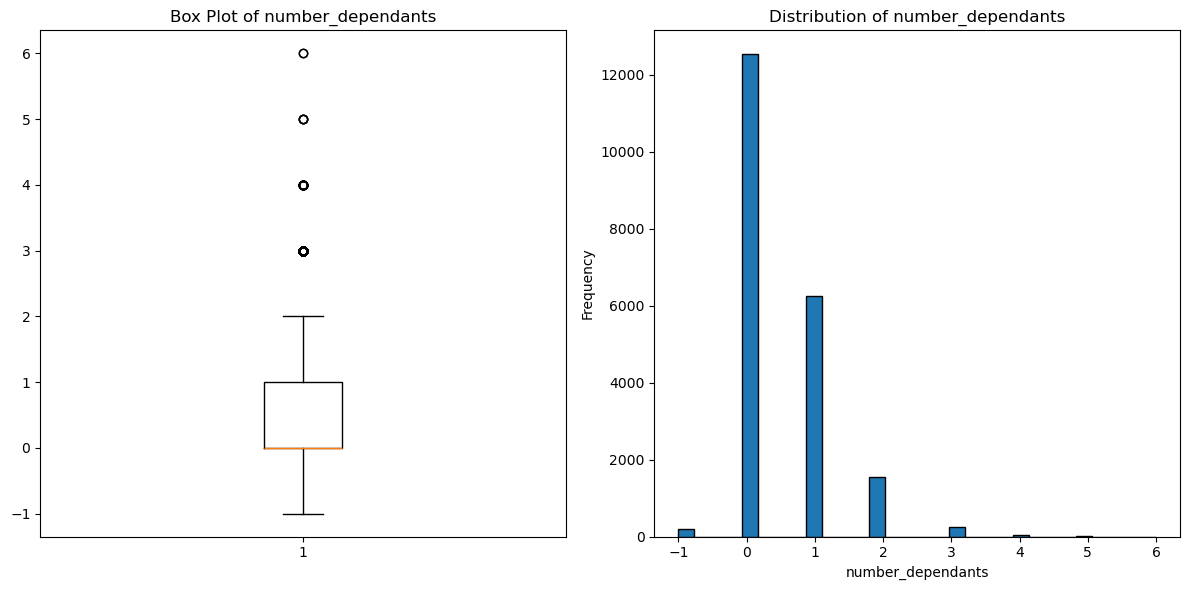

In [28]:
cur_var = 'number_dependants'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### credit_utilization

This variable denotes the ratio of credit utilized by the customer. It ranges from 0 to 1.

The histogram is heavily right-skewed, with most observations near the lower end (close to 0) and a long tail stretching toward higher values (up to around 0.5). The box plot confirms that a large number of observations are clustered around relatively low credit utilization, with many points above the upper whisker identified as outliers.

In many lending scenarios, high credit utilization can be an indicator of elevated financial stress and may correlate with a higher risk of default. Also, it is possible for a customer to have a high credit utilization rate, and a higher number of credit utilization rate could be associated with higher financial burdens, so these outliers might be relevant for modeling or risk analysis, and thus they will not be removed or winsorized at this stage. 

The plan is to test multiple tree based ensembling methods for this project, which normally don't assume linearity. Also, the ordering of data points remains the same after a log transforamtion, and the splits will be basically unaffected, so a log transformation seems unnecessary.


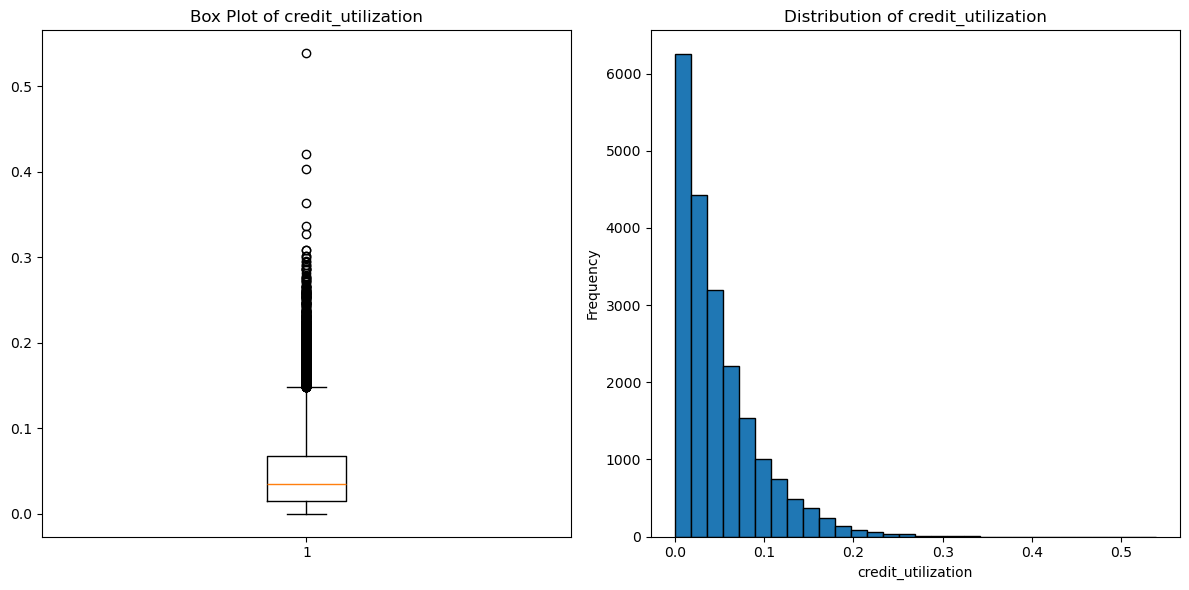

In [29]:
cur_var = 'credit_utilization'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### debt_to_income_ratio

This variable denotes the ratio of debt to income for the customer. 

The histogram appears roughly bell-shaped and centered around 0.35. This suggests that many borrowers have a debt-to-income ratio near 35%, and there are few borrowers with extremely low or extremely high ratios. There are a number of points above 0.7, which could be flagged as outliers. While high ratios are less common, they may be significant for predicting default risk.


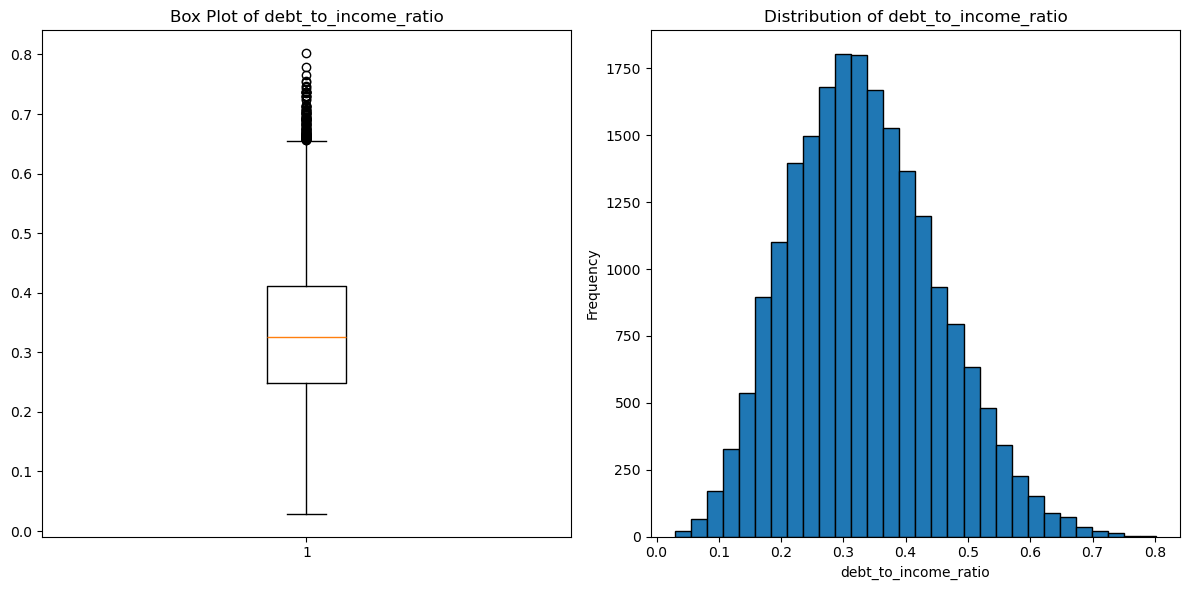

In [30]:
cur_var = 'debt_to_income_ratio'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### monthly_income

This variable denotes the monthly income for the customer. 

The histogram shows a right-skewed distribution, with most observations clustering around the lower end (just under 2,000) and a tail stretching toward higher incomes. But this skew is common for income data; a few borrowers have significantly higher incomes, but most have lower income. The boxplot shows many points above 3000 and are flagged as outliers. However, these may be legitimate higher-income borrowers rather than data errors—income naturally varies widely.


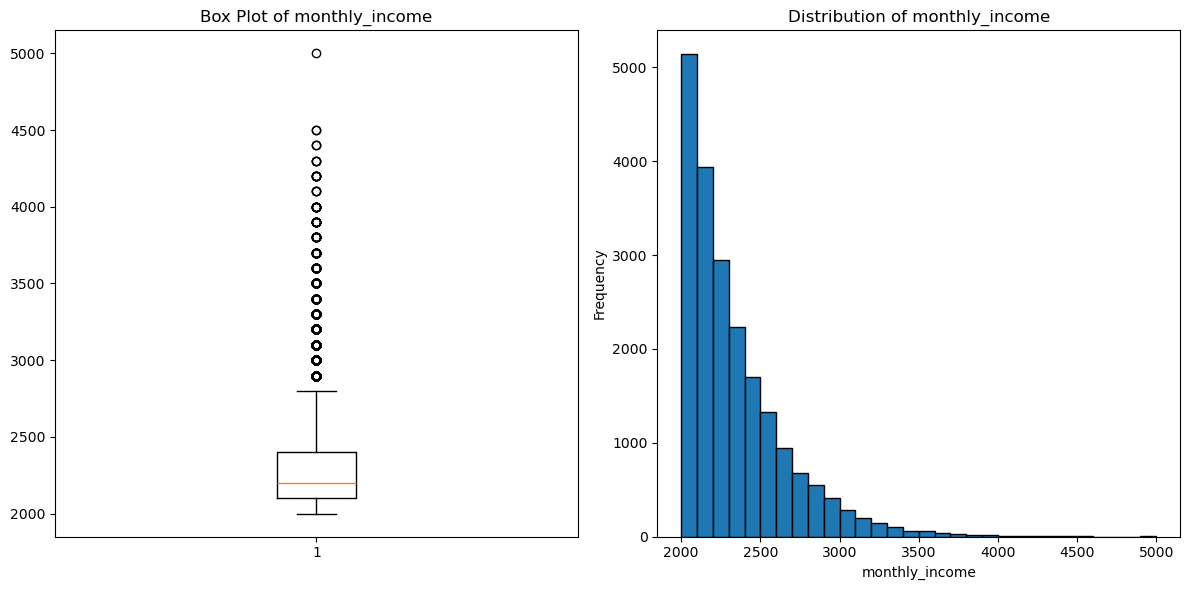

In [31]:
cur_var = 'monthly_income'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### number_open_credit_lines

This variable denotes the number of open credit lines for the customer. A credit line is a credit facility that allows a borrower to access funds as needed, up to a pre-set limit, and pay them back over time, with interest charged only on the amount borrowed.

The histogram shows a roughly bell-shaped distribution centered around 5 open credit lines. Values range from 0 to around 14 or 15, indicating some borrowers have no open lines of credit while others have quite a few.

A higher number of open credit lines could reflect a borrower’s active credit profile. It might indicate experience handling credit, but it can also signal potential overextension, depending on the borrower’s payment history and credit limits. There don’t appear implausible values.


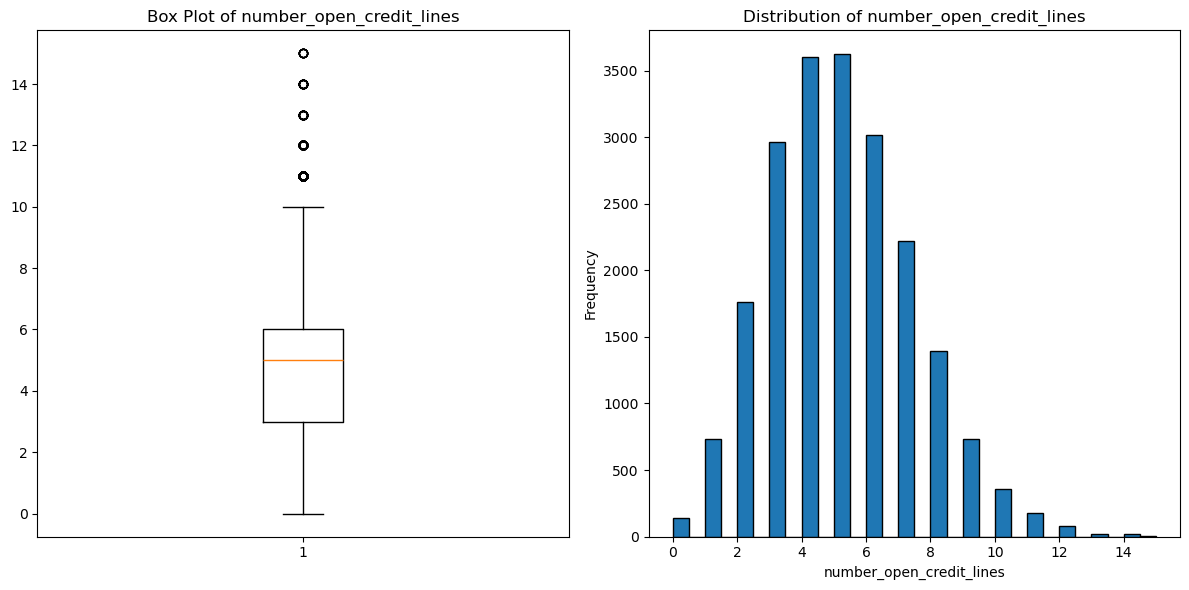

In [32]:
cur_var = 'number_open_credit_lines'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### number_open_loans

This variable denotes the number of open loans for the customer.  

The histogram is right-skewed: most borrowers have a small number of open loans (0–2), and only a minority have more than 3 or 4. Observations above 4 or 5 appear as outliers, but these may represent legitimate borrowers who carry multiple loans simultaneously.

There are no apparent negative or non-integer values. This aligns well with what we would expect for a count of open loans. Borrowers with a higher number of open loans might be more leveraged, potentially increasing their default risk. However, they may also be more financially experienced.


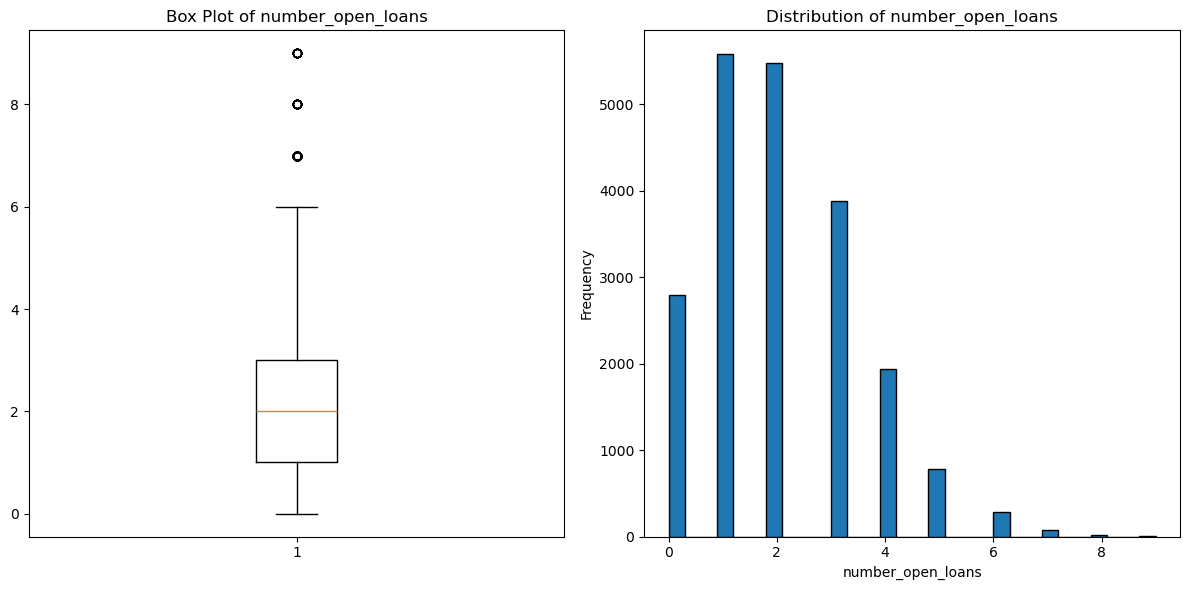

In [33]:
cur_var = 'number_open_loans'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### number_90_days_past_due

This variable denotes the count of 90 days past due instance for the customer.  

The histogram is heavily right-skewed, with most borrowers at 0 (no 90-day delinquencies). A small number of borrowers have 1, 2, or more 90-day past-due instances, which appear as outliers on the box plot. Values of 1, 2, or 3 are flagged as outliers but may be valid borrowers with repeated late payments.

Having 90-day past-due accounts is often a strong signal of credit distress and could be highly predictive of default risk.


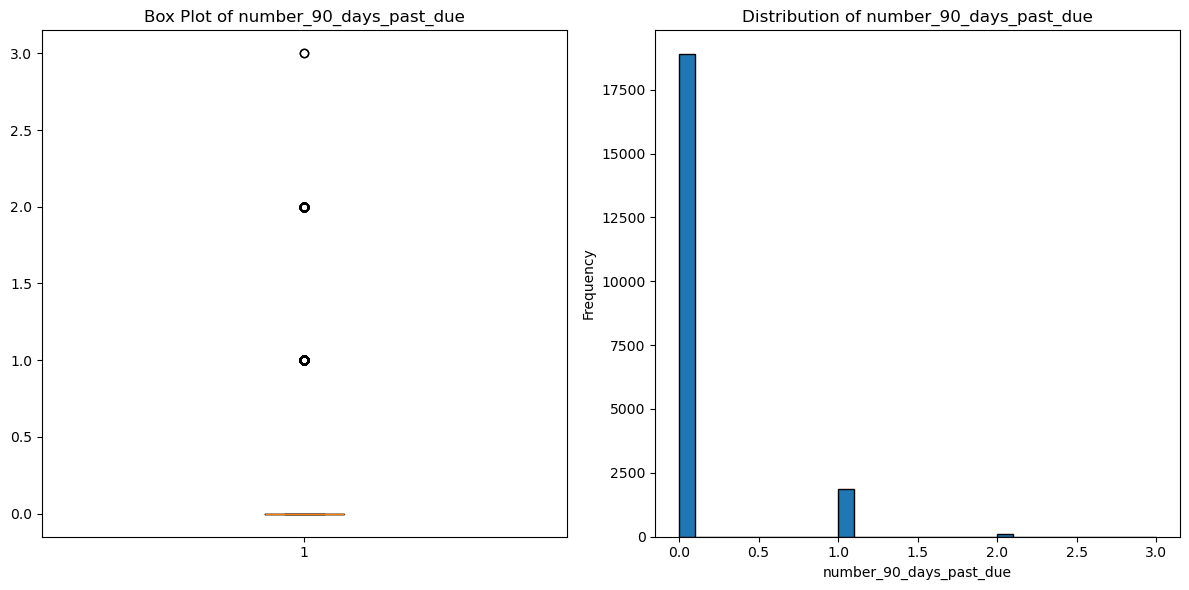

In [34]:
cur_var = 'number_90_days_past_due'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### number_charged_off

This variable denotes the count of charged off instance for the customer.  

The histogram is heavily right-skewed, with the vast majority of observations at 0 (no charged-off loans). A small number of observations have 1, 2, or 3 charged-off loans, appearing as outliers on the box plot. Values above 1 are treated as outliers, though they may be legitimate cases representing borrowers with multiple charged-off accounts.

Having even a single charged-off account is often a strong indicator of past credit problems and can significantly increase the likelihood of future default.


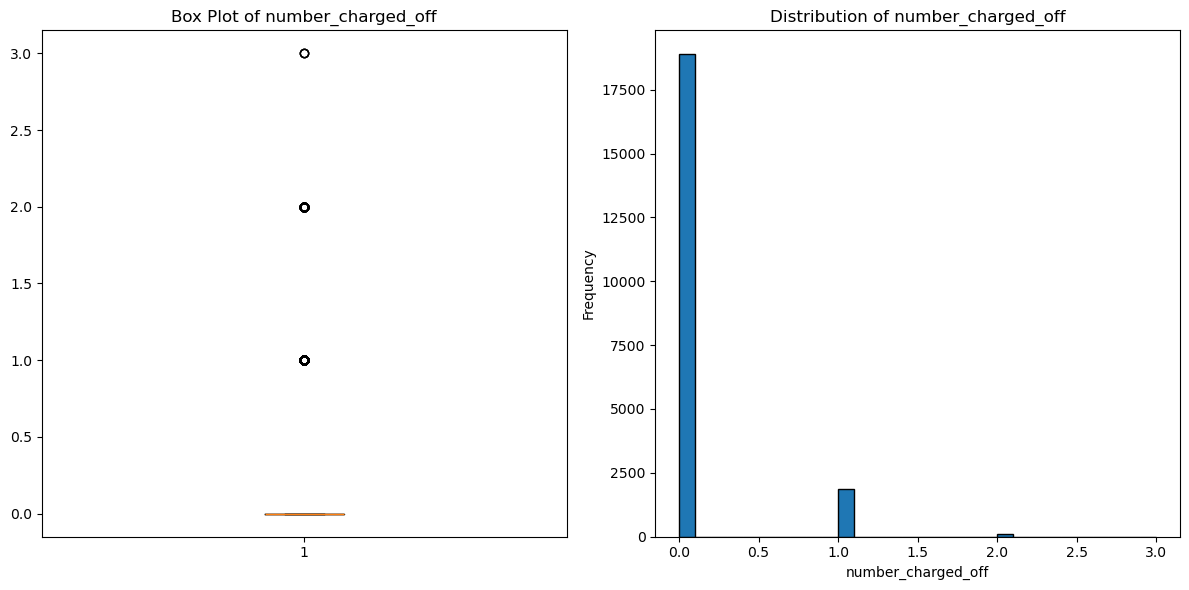

In [35]:
cur_var = 'number_charged_off'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### score1

This variable denotes the credit score for the customer. 

The histogram looks relatively evenly spread across the 500–850 range. There is no heavy skew, and the distribution does not show extreme tails. The box plot suggests basically no outliers.



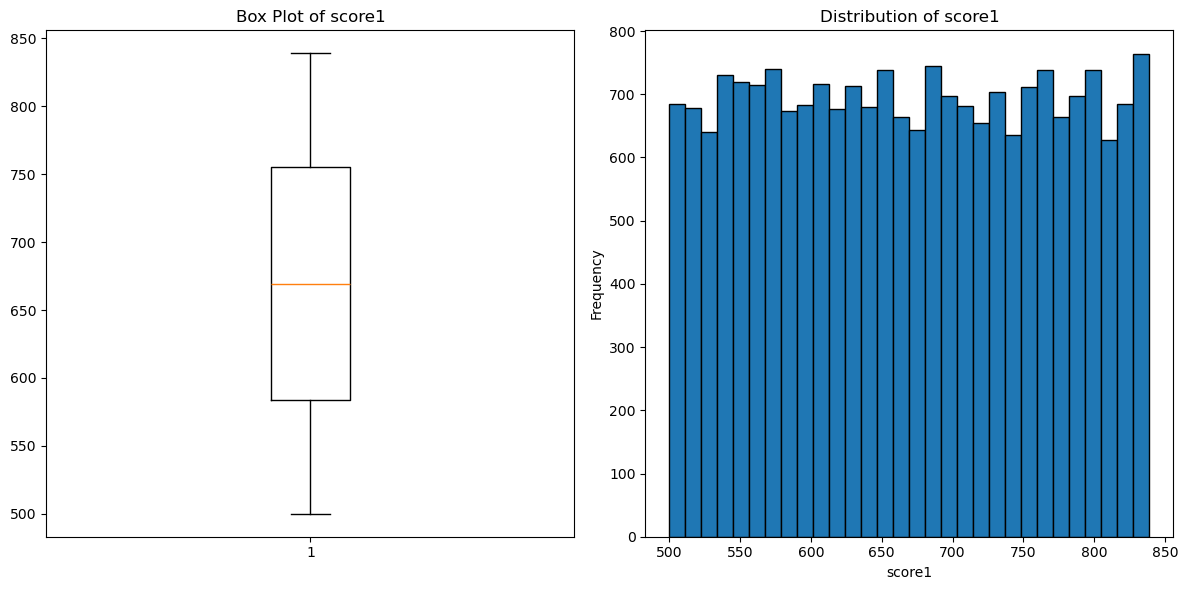

In [36]:
cur_var = 'score1'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### score2

This variable denotes another credit score for the customer. It is similar to score2

The histogram looks relatively evenly spread across the 500–850 range. There is no heavy skew, and the distribution does not show extreme tails. The box plot suggests basically no outliers.

However, the correlation coefficient for score1 and score2 is not high (0.011557), suggesting that the customer could have very different credit scores under two scoring system.


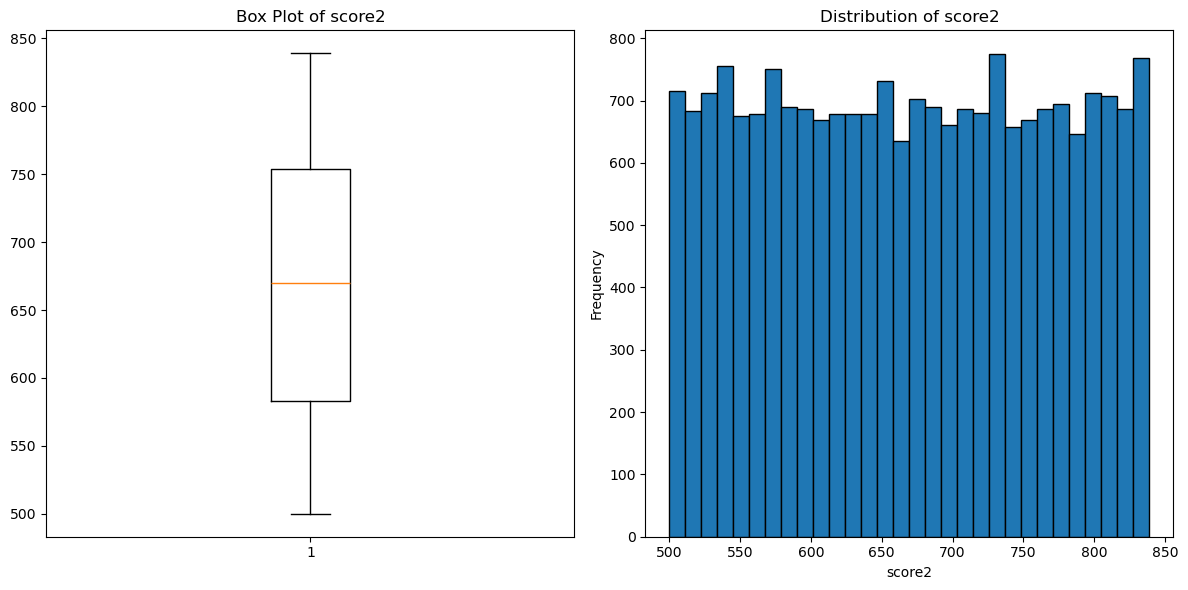

In [37]:
cur_var = 'score2'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [38]:
data[['score1','score2']].corr()

,score1,score2
score1,1.000000,0.011557
score2,0.011557,1.000000


##### age

This variable is directly built based on the original variable date of birth, and indicates customer's age as of March 31, 2025.

The histogram suggests most borrowers are between about 25 and 100 years old. However, there are entries extending up to nearly 200, which are flagged as outliers on the box plot. Extremely high ages (e.g., above 120) are generally implausible and may indicate data-entry errors, placeholder values, or special cases that need validation. In this case, it is assumed that extreme high ages are due to data-entry errors, and all years that start with 18xx are replaced with 19xx. For example, a date of birth 1829-06-03 is transformed to 1929-06-03. The variable age will be updated after the transformation happen.

Age can be correlated with different credit behaviors (e.g., older borrowers might have more stable finances or might be on a fixed income).

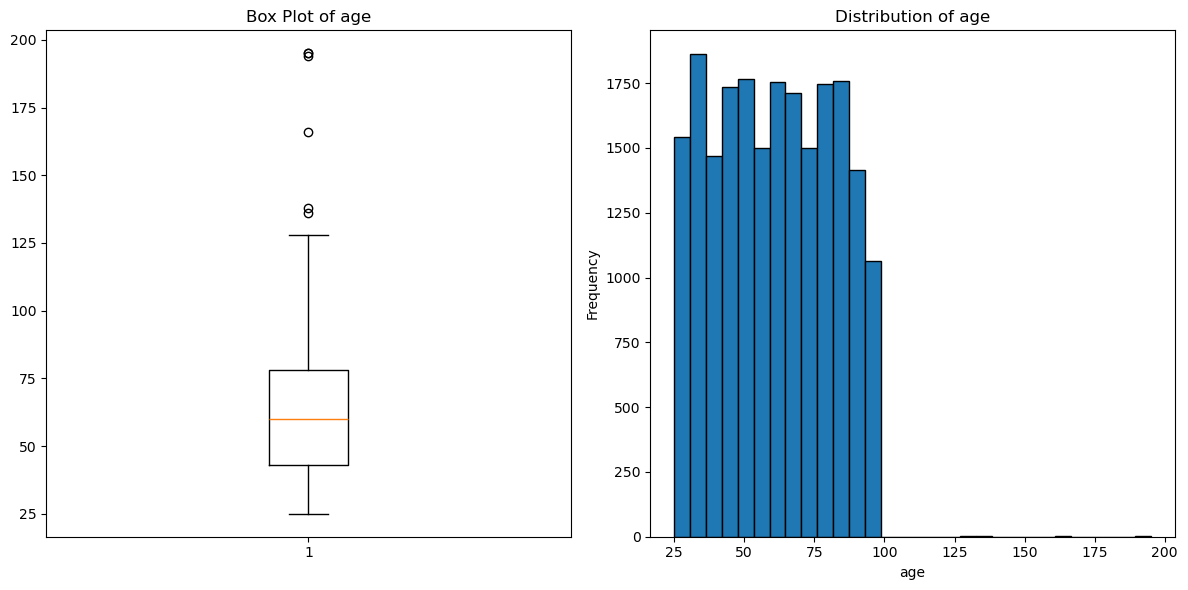

In [39]:
cur_var = 'age'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot(data[cur_var])
axes[0].set_title(f'Box Plot of {cur_var}')

axes[1].hist(data[cur_var], bins=30, edgecolor='black')
axes[1].set_title(f'Distribution of {cur_var}')
axes[1].set_xlabel(cur_var)
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

##### target

The y variable that denote if a customer default on his or her loan. As the bar plot shows, the dataset is imbalanced, default / non-default is approximately 0.1, which suggests resampling might be required for this project.

<Axes: title={'center': 'Count of Default vs Non-Default'}, xlabel='target'>

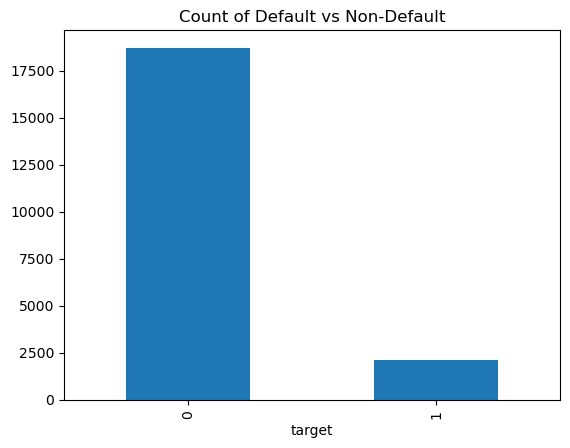

In [40]:
data['target'].value_counts().plot(kind='bar', title='Count of Default vs Non-Default')

#### Bivariate Analysis

Based on the box plots below, it is clear that the customer that default and the csutomers that do not default have very different monthly income, number_open_credit_lines, score1 and score2 distributions. The heatmap in the end also indicates that there basically exists no correlation among all the numerical features.

In [41]:
numerical_features = ['number_dependants', 'credit_utilization',
       'debt_to_income_ratio', 'monthly_income', 'number_open_credit_lines',
       'number_open_loans', 'number_90_days_past_due', 'number_charged_off',
       'score1', 'score2', 'age']

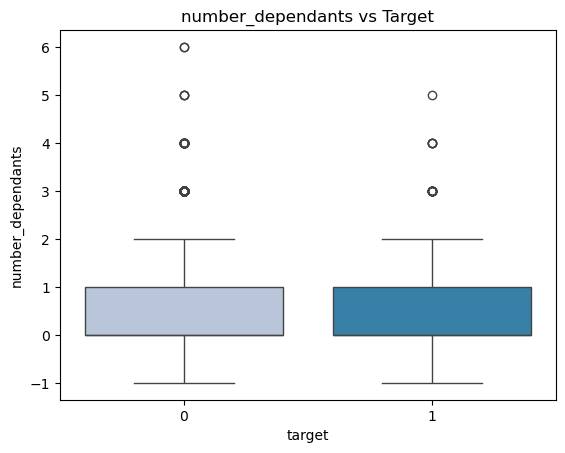

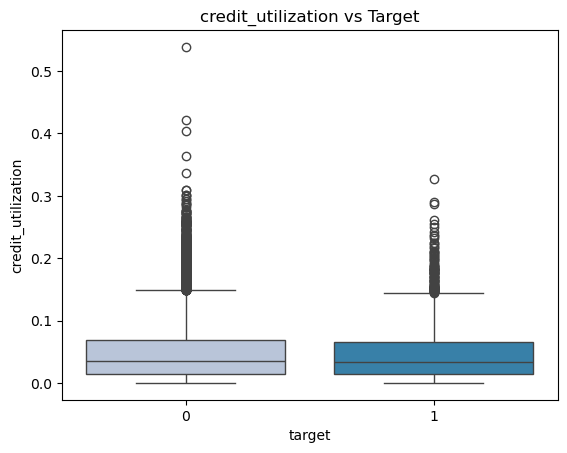

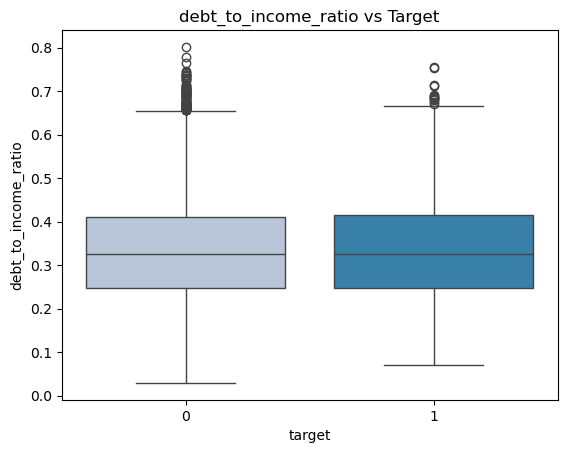

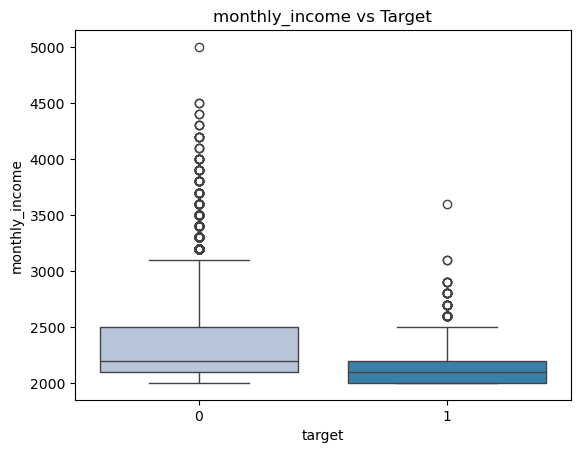

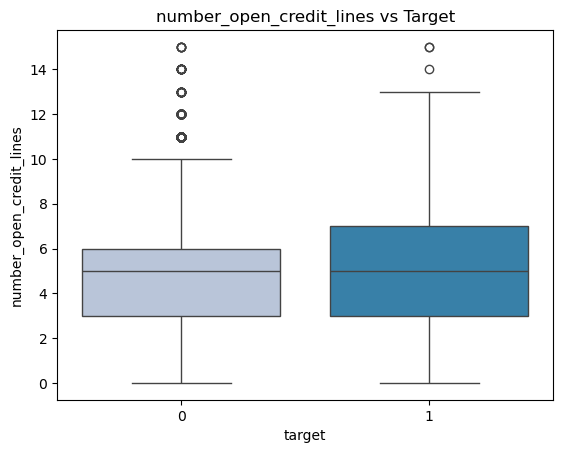

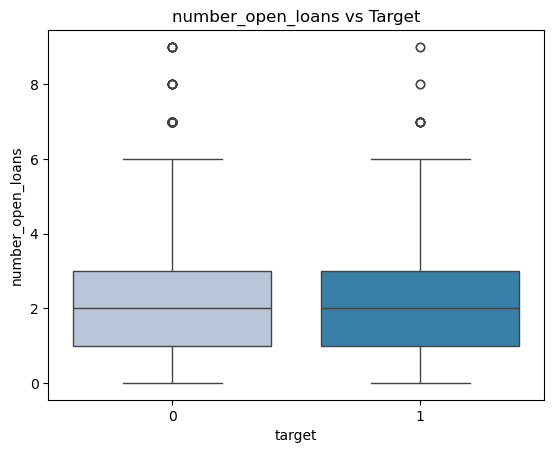

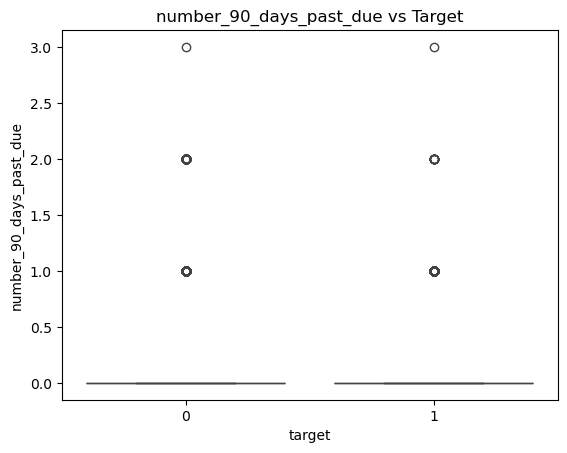

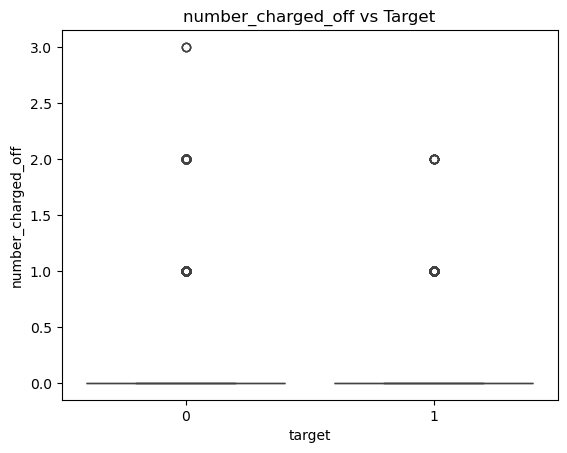

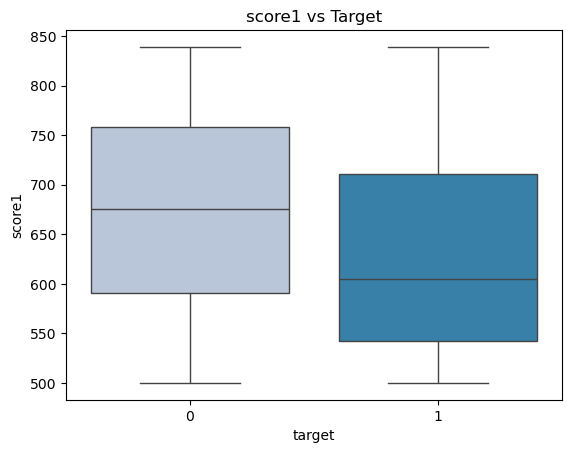

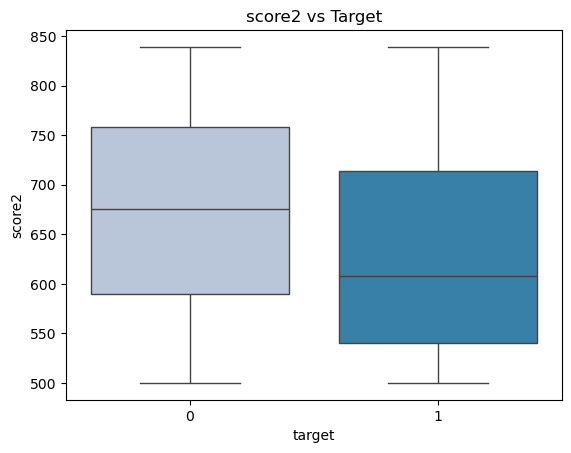

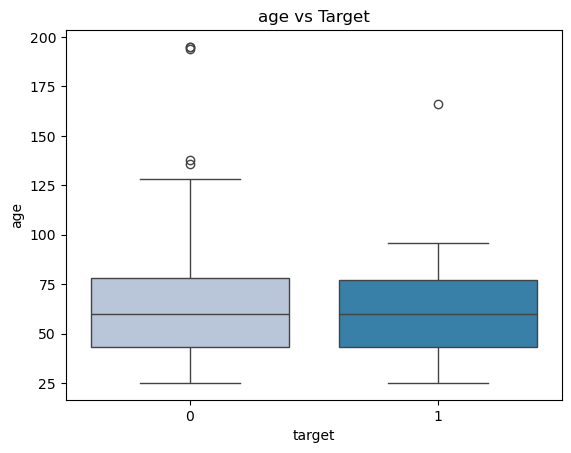

In [42]:
for i in numerical_features:
    sns.boxplot(x=data['target'], y=data[i], palette='PuBu')
    plt.title(i + ' vs Target')
    plt.show()

<Axes: xlabel='target', ylabel='number_dependants'>

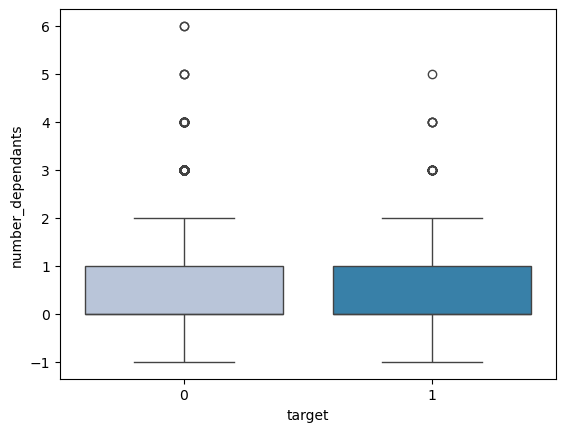

In [43]:
sns.boxplot(x=data['target'], y=data['number_dependants'], palette='PuBu')

<Axes: >

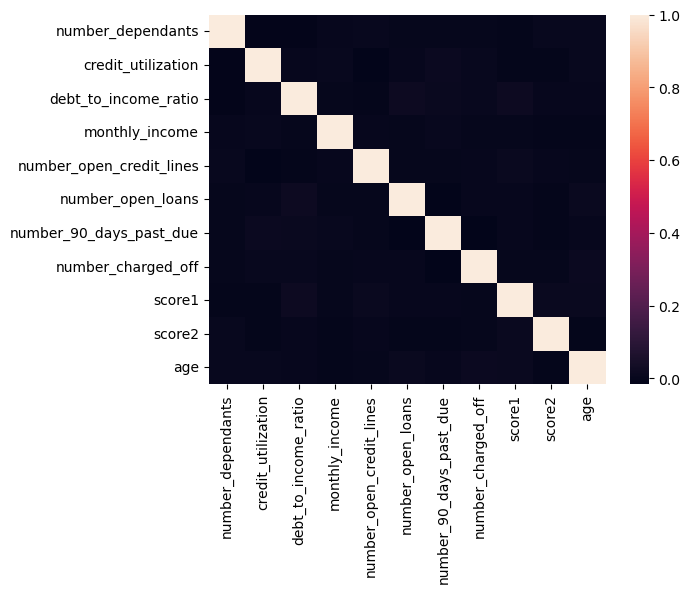

In [44]:
sns.heatmap(data[numerical_features].corr())

## Basic Data Cleaning

In [45]:
df = data.copy()


For date of birth with a year earlier than 1900, assume they are due to misclicks and add 100 years. (e.g. 1829 -> 1929) Then compute age again.

It does not make sense for number_dependants < -1, so set them to be 0, which is also the mode for number_dependants.

Drop date of birth and id.


In [46]:
df['date_of_birth'] = df['date_of_birth'].apply(lambda x: x + pd.DateOffset(years=100) if x.year < 1900 else x)
df['age'] = df['date_of_birth'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
df['number_dependants'] = df['number_dependants'].apply(lambda x: 0 if x == -1 else x)

df = df.drop(columns=['date_of_birth', 'id'])

### Check Outliers

Although there seem to have outliers, many of them kind of make sense in real life, so these records are kept and will not be processed in an attempt to reflect the true data distribution and what might be encountered in real life operation.

In [47]:
for i in df.columns:
    Q1 = np.nanquantile(df[i], 0.25) # 25th quantile
    Q3 = np.nanquantile(df[i], 0.75)  # 75th quantile
    IQR = Q3 - Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    cur_i = df[i]
    print('----- working on column ' + i)
    print(cur_i[(cur_i < Lower_Whisker) | (cur_i > Upper_Whisker)])

----- working on column number_dependants
20       3
37       3
102      3
126      3
183      3
        ..
20611    3
20620    3
20653    3
20736    3
20825    3
Name: number_dependants, Length: 292, dtype: int64
----- working on column credit_utilization
60       0.150175
61       0.149005
90       0.205110
205      0.237294
232      0.170292
           ...   
20769    0.151933
20781    0.308744
20805    0.152181
20819    0.157247
20837    0.164027
Name: credit_utilization, Length: 890, dtype: float64
----- working on column debt_to_income_ratio
347      0.660320
457      0.737766
857      0.702218
1451     0.668460
1577     0.656696
           ...   
20227    0.694969
20356    0.657667
20487    0.661444
20709    0.737418
20765    0.666215
Name: debt_to_income_ratio, Length: 119, dtype: float64
----- working on column monthly_income
2        3000
60       3200
70       3000
81       2900
87       3500
         ... 
20797    3300
20822    3000
20826    3000
20834    2900
20838    3200

## Feature Exploration, Train-Test Split, and Base Model as the Benchmark: Logistic Regression

### Feature Exploration: 

Use KS score to evaluate feature's capability of differentiating the customers that will default from those who will not default.

In [48]:
initial_num_vars = len(df.columns) - 1
initial_filter_score = pd.DataFrame(np.zeros((initial_num_vars,2)))
initial_filter_score.columns = ['variable','filter score']   

goods = df[df['target'] == 0]
bads = df[df['target'] == 1]

j = 0
for column in df.columns:
    if column != 'target':
        initial_filter_score.loc[j,'variable'] = column
        initial_filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column], bads[column])[0]
        j = j+1

initial_filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
initial_filter_score.dropna(inplace=True)

In [49]:
initial_filter_score

,variable,filter score
3,monthly_income,0.257960
8,score1,0.209164
9,score2,0.201894
1,credit_utilization,0.027049
4,number_open_credit_lines,0.020122
10,age,0.019254
5,number_open_loans,0.017809
2,debt_to_income_ratio,0.015279
6,number_90_days_past_due,0.004166
0,number_dependants,0.003981


### Train Test Split

Set stratify equals to y so that the data distribution is not changed. Treat the testing set as the hold-out ground and use it to unbiasedly evaluate model performance in the end.

In [50]:
from sklearn.model_selection import train_test_split

# Sample data
X = df.drop(columns=['target'])
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [51]:
X_test.shape

(5210, 11)

In [52]:
initial_default_ratio = y.mean()
# after_default_ratio = y_train.mean() * len(y_train) / (df['target'].mean() * df.shape[0])
after_default_ratio = y_train.mean()
print(f'Before train test split, the ratio of default customers is {initial_default_ratio}')
print(f'After train test split, the ratio of default customers is {after_default_ratio}')

Before train test split, the ratio of default customers is 0.10216421133451702
After train test split, the ratio of default customers is 0.10218184144858916


### Base Model: Logistic Regression

A simple model as a starting point. Seems that with original and log transformed variables, the logistic regression model does not have a good performance. Try to brainstorm new features and try resampling to rebalance the dataset.

In [53]:
X_base = df.drop(columns=['target'])
X_base['number_dependants'] = X_base['number_dependants'].apply(lambda x: np.log1p(x))
X_base['monthly_income'] = X_base['monthly_income'].apply(lambda x: np.log1p(x))
X_base['credit_utilization'] = X_base['credit_utilization'].apply(lambda x: np.log1p(x))

y_base = df['target']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.25, random_state=42, stratify=y)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_base, y_train_base)
y_pred_log_base = log_reg.predict(X_test_base)
y_proba_log_base = log_reg.predict_proba(X_test_base)[:, 1]

print("Average Precision (PR-AUC):", average_precision_score(y_test_base, y_proba_log_base))
print("Classification Report:\n", classification_report(y_test_base, y_pred_log_base))


Average Precision (PR-AUC): 0.16198161018051832
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      4678
           1       0.00      0.00      0.00       532

    accuracy                           0.90      5210
   macro avg       0.45      0.50      0.47      5210
weighted avg       0.81      0.90      0.85      5210



In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

print("Average Precision (PR-AUC):", average_precision_score(y_test, y_proba_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))


Average Precision (PR-AUC): 0.17344520644951994
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      4678
           1       0.00      0.00      0.00       532

    accuracy                           0.90      5210
   macro avg       0.45      0.50      0.47      5210
weighted avg       0.81      0.90      0.85      5210



## Creating New Features on Training Set

5 General types of features are engineered and 46 new features were generated:
- Credit & Account Features (7 New Features)
- Debt & Income Features (17 New Features)
- Dependents & Demographic Features (3 New Features)
- Credit Score Features (7 New Features)
- Repayment History and Delinquency (12 New Features)
 

In the end, pairwise interaction terms are created. 1642 new features in total were generated through this step.

In [56]:
from sklearn.preprocessing import QuantileTransformer

In [57]:
# ---------------------------
# 1. Credit & Account Features
# ---------------------------
# Total Credit Accounts: Sum of open credit lines and open loans
X_train['total_credit_accounts'] = X_train['number_open_credit_lines'] + X_train['number_open_loans']

# Binary Flag for Having Both Credit Lines and Loans
X_train['has_both_credit_and_loans'] = ((X_train['number_open_credit_lines'] > 0) & (X_train['number_open_loans'] > 0)).astype(int)

# Difference Between Credit Lines and Open Loans
X_train['credit_line_loan_diff'] = X_train['number_open_credit_lines'] - X_train['number_open_loans']

# Loan Fraction and Credit Line Fraction
X_train['loan_fraction'] = X_train['number_open_loans'] / (X_train['total_credit_accounts'] + 1)
X_train['credit_line_fraction'] = X_train['number_open_credit_lines'] / (X_train['total_credit_accounts'] + 1)

# Credit Exposure Index: credit_utilization multiplied by total credit accounts
X_train['credit_exposure'] = X_train['credit_utilization'] * X_train['total_credit_accounts']

# Credit Accounts per Age: Normalize total accounts by age
X_train['accounts_per_age'] = X_train['total_credit_accounts'] / (X_train['age'] + 1)

# ---------------------------
# 2. Debt & Income Features
# ---------------------------
# Estimated Debt Amount: Approximate debt burden = monthly_income * debt_to_income_ratio
X_train['estimated_debt'] = X_train['monthly_income'] * X_train['debt_to_income_ratio']

# Estimated Income After Debt: Approximate debt burden = monthly_income * (1 - debt_to_income_ratio)
X_train['disposable_income'] = X_train['monthly_income'] * (1 - X_train['debt_to_income_ratio'])

# Debt-to-Income Interaction: Product of debt_to_income_ratio and credit_utilization
X_train['dti_credit_util_interaction'] = X_train['debt_to_income_ratio'] * X_train['credit_utilization']

# 
X_train['income_per_dependant'] = X_train['monthly_income'] / (X_train['number_dependants'] + 1)
X_train['disposable_income_per_depandent'] = X_train['disposable_income'] / (X_train['number_dependants'] + 1)

# Income per Credit Account: monthly_income divided by total credit accounts
# Plus 1 to total_credit_accounts to avoid division errors
X_train['income_per_account'] = X_train['monthly_income'] / (X_train['total_credit_accounts'] + 1)
X_train['income_per_loan'] = X_train['monthly_income'] / (X_train['number_open_loans'] + 1)
X_train['income_per_credit_line'] = X_train['monthly_income'] / (X_train['number_open_credit_lines'] + 1)

X_train['disposable_income_per_account'] = X_train['disposable_income'] / (X_train['total_credit_accounts'] + 1)
X_train['disposable_income_per_loan'] = X_train['disposable_income'] / (X_train['number_open_loans'] + 1)
X_train['disposable_income_per_credit_line'] = X_train['disposable_income'] / (X_train['number_open_credit_lines'] + 1)

# Debt Pressure Ratio: the ratio of debt obligations to the remaining income
epsilon = 0.00001  # small constant to avoid division by zero
X_train['debt_pressure_ratio'] = X_train['debt_to_income_ratio'] / (1 - X_train['debt_to_income_ratio'] + epsilon)

# Financial Cushion Ratio (inverse of Debt Pressure Ratio)
X_train['financial_cushion_ratio'] = (1 - X_train['debt_to_income_ratio']) / (X_train['debt_to_income_ratio'] + epsilon)

# Creating Categorical Variables
# Debt Tier/Bin: Categorize debt_to_income_ratio into quartiles
debt_tier_quantile_transformer = QuantileTransformer(n_quantiles=min(1000, len(X_train)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_train['debt_tier'] = debt_tier_quantile_transformer.fit_transform(X_train[['debt_to_income_ratio']])

# Disposable Income Tier: Categorize disposable income into quartiles
disposable_income_quantile_transformer = QuantileTransformer(n_quantiles=min(1000, len(X_train)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_train['disposable_income_tier'] = disposable_income_quantile_transformer.fit_transform(X_train[['disposable_income']])

# Relative Income Rank: Percentile ranking of monthly_income
income_quantile_transformer = QuantileTransformer(n_quantiles=min(1000, len(X_train)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_train['income_tier'] = income_quantile_transformer.fit_transform(X_train[['monthly_income']])

# Debt Burden Relative to Median Income: 
# Calculate estimated debt and compare it with the median monthly income
median_income = X_train['monthly_income'].median()
X_train['debt_to_median_income_ratio'] = (X_train['monthly_income'] * X_train['debt_to_income_ratio']) / median_income

# ---------------------------
# 3. Dependants & Demographic Features
# ---------------------------
# Household Size: Assume the customer is part of the household
X_train['household_size'] = X_train['number_dependants'] + 1

# Dependants Share: Proportion of household members who are dependants
X_train['dependants_share'] = X_train['number_dependants'] / X_train['household_size']

# Dependants-to-Age Ratio: number_dependants divided by age (avoid division by zero)
X_train['dependants_to_age'] = X_train['number_dependants'] / (X_train['age'] + epsilon)

# ---------------------------
# 4. Credit Score Features
# ---------------------------
# Average Credit Score: Mean of score1 and score2
X_train['avg_credit_score'] = (X_train['score1'] + X_train['score2']) / 2

# Normalized Credit Score Difference: Absolute difference between score1 and score2
X_train['norm_credit_score_diff'] = np.abs(X_train['score1'] - X_train['score2']) / (X_train['avg_credit_score'] + epsilon)

# Credit Score Ratio: Alternative way to assess difference between scoring models
X_train['credit_score_ratio'] = X_train['score1'] / (X_train['score2'] + epsilon)

# Score Interaction Term: Product of score1 and score2
X_train['score_product'] = X_train['score1'] * X_train['score2']

# Percentile Ranks for Score1 and Score2
score1_quantile_transformer = QuantileTransformer(n_quantiles=min(1000, len(X_train)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_train['score1_percentile'] = score1_quantile_transformer.fit_transform(X_train[['score1']])

score2_quantile_transformer = QuantileTransformer(n_quantiles=min(1000, len(X_train)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_train['score2_percentile'] = score2_quantile_transformer.fit_transform(X_train[['score2']])

# Rank Order Scaling to Combine the Two Scores
X_train['Rank_Order_Scaling_avg_credit_score'] = (X_train['score1_percentile'] + X_train['score2_percentile']) / 2

# ---------------------------
# 5. Repayment History and Delinquency
# ---------------------------
# Delinquency Flags: Create binary features for any 90 days past due or charged off events
X_train['flag_90_days_past_due'] = (X_train['number_90_days_past_due'] > 0).astype(int)
X_train['flag_charged_off'] = (X_train['number_charged_off'] > 0).astype(int)

# Aggregate Delinquency Score: Sum of number_90_days_past_due and number_charged_off
X_train['aggregate_delinquency'] = X_train['number_90_days_past_due'] + X_train['number_charged_off']

# Weighted Delinquency Score: Charged-offs are weighted more heavily
X_train['weighted_delinquency'] = X_train['number_90_days_past_due'] + 2 * X_train['number_charged_off']

# Delinquency Ratios: Normalize delinquency counts by total credit accounts
X_train['ratio_90_days_to_total_accounts'] = X_train['number_90_days_past_due'] / (X_train['total_credit_accounts'] + 1)
X_train['ratio_charged_off_to_total_accounts'] = X_train['number_charged_off'] / (X_train['total_credit_accounts'] + 1)

# Delinquency Ratio per Loan: Normalize past due events by the number of open loans
X_train['past_due_rate'] = X_train['number_90_days_past_due'] / (X_train['number_open_loans'] + 1)

# Aggregate Delinquency per Credit Account: Normalize total delinquency events by total credit accounts
X_train['delinquency_per_account'] = (X_train['number_90_days_past_due'] + X_train['number_charged_off']) / (X_train['total_credit_accounts'] + 1)

# Delinquency Impact Score: Combine weighted delinquency with the debt-to-income ratio
X_train['delinquency_impact'] = X_train['weighted_delinquency'] * X_train['debt_to_income_ratio']

# Chronic Delinquency Flag: Flag customers with more than 1 event (either past due or charged off)
X_train['chronic_delinquency'] = ((X_train['number_90_days_past_due'] > 1) | (X_train['number_charged_off'] > 1)).astype(int)

# Delinquency Exposure Relative to Age: Normalize aggregate delinquency by age
X_train['delinquency_exposure'] = (X_train['number_90_days_past_due'] + X_train['number_charged_off']) / (X_train['age'] + epsilon)

# Delinquency-Credit Utilization Interaction: Interaction between delinquency and credit utilization
X_train['delinquency_util_interaction'] = (X_train['number_90_days_past_due'] + X_train['number_charged_off']) * X_train['credit_utilization']

# ---------------------------
# 6. Interaction Features
# ---------------------------
cur_column_list = list(X_train.columns)
for i in range(len(cur_column_list)):
    j = i + 1
    while j < len(cur_column_list):
        cur_string = str(cur_column_list[i]) + '_interact_' + str(cur_column_list[j])
        X_train[cur_string] = X_train[cur_column_list[i]] * X_train[cur_column_list[j]]
        j += 1

In [58]:
X_train.columns

Index(['number_dependants', 'credit_utilization', 'debt_to_income_ratio',
       'monthly_income', 'number_open_credit_lines', 'number_open_loans',
       'number_90_days_past_due', 'number_charged_off', 'score1', 'score2',
       ...
       'delinquency_per_account_interact_delinquency_impact',
       'delinquency_per_account_interact_chronic_delinquency',
       'delinquency_per_account_interact_delinquency_exposure',
       'delinquency_per_account_interact_delinquency_util_interaction',
       'delinquency_impact_interact_chronic_delinquency',
       'delinquency_impact_interact_delinquency_exposure',
       'delinquency_impact_interact_delinquency_util_interaction',
       'chronic_delinquency_interact_delinquency_exposure',
       'chronic_delinquency_interact_delinquency_util_interaction',
       'delinquency_exposure_interact_delinquency_util_interaction'],
      dtype='object', length=1653)

In [59]:
X_train

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,...,delinquency_per_account_interact_delinquency_impact,delinquency_per_account_interact_chronic_delinquency,delinquency_per_account_interact_delinquency_exposure,delinquency_per_account_interact_delinquency_util_interaction,delinquency_impact_interact_chronic_delinquency,delinquency_impact_interact_delinquency_exposure,delinquency_impact_interact_delinquency_util_interaction,chronic_delinquency_interact_delinquency_exposure,chronic_delinquency_interact_delinquency_util_interaction,delinquency_exposure_interact_delinquency_util_interaction
16239,0,0.052097,0.085415,2100,3,4,0,0,671,661,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
16869,0,0.046523,0.608909,2300,7,1,0,0,779,678,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
12510,0,0.061258,0.349166,3000,7,2,0,0,720,724,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
13040,0,0.022394,0.403905,2000,5,1,0,0,532,568,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
1909,0,0.063979,0.430780,2000,8,2,0,0,510,776,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,1,0.076418,0.443570,2000,3,2,0,0,725,592,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
14305,2,0.000877,0.253466,2300,5,3,1,0,750,720,...,0.028163,0.0,0.001263,0.000097,0.0,0.002880,0.000222,0.0,0.0,0.00001
2869,2,0.029247,0.193698,3100,2,5,0,0,657,760,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
4041,0,0.023184,0.155154,2000,7,1,1,0,725,566,...,0.017239,0.0,0.001292,0.002576,0.0,0.001804,0.003597,0.0,0.0,0.00027


## SMOTE to Address Imbalance, Standardize Features and Conduct Feature Selection on Training Set

After feature engineering, since the original dataset is imbalanced, resampling is conducted to ensures the model pays sufficient attention to the minority calss (defaulters) and reduce false negative. The original default/non-default ratio is 1/9, and I wish to try a combination of undersampling and SMOTE since relying solely on undersampling might lose too much information about the majority class and relying solely on SMOTE, which reates synthetic examples of the minority class to increase its representation, may lead to overfitting.

A grid search is conducted to find out the best parameters for undersampling to randomly remove some of the records from the majority class and SMOTE for oversampling the minority class. The result suggests undersample the majority class so that the default/non-default ratio increases to 1/2, and then conduct SMOTE to generate new records for minority class so that the ratio could increases to 3/4. 

### Grid Search

In [60]:
y_train.sum() * 2 * 3 / 4 - y_train.sum()


798.5

In [61]:
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, average_precision_score

# Create a pipeline that first downsamples, then applies SMOTE, and finally trains a classifier
pipeline = ImbPipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LGBMClassifier(n_estimators=20,num_leaves=4))
])

param_grid = {
    'under__sampling_strategy': [1/1, 1/1.5, 1/2, 1/2.5, y.mean()*2, y.mean()],
    'smote__sampling_strategy': [0, 1/2, 0.75, 1],
}

# Use average_precision_score as the scoring metric
scorer = make_scorer(average_precision_score)

# Set up GridSearchCV with stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(X_train, y_train)

smote_grid_result = pd.DataFrame(grid_search.cv_results_)

# Best parameters and corresponding score
print("Best Parameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validated average_precision_score: {grid_search.best_score_:.4f}")



Fitting 4 folds for each of 24 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 2395, number of negative: 3194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344966
[LightGBM] [Info] Number of data points in the train set: 5589, number of used features: 1653
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428520 -> initscore=-0.287891
[LightGBM] [Info] Start training from score -0.287891
Best Parameters:
{'smote__sampling_strategy': 0.75, 'under__sampling_strategy': 0.5}
Best Cross-Validated average_precision_score: 0.1863


In [62]:
# smote_grid_result.dropna().sort_values(by=['mean_test_score', 'mean_train_score'], ascending=[False, False])

In [63]:
# Downsample
X_train_ds = X_train.copy()
X_train_ds['target'] = y_train

X_train_ds_neg = X_train_ds[X_train_ds['target'] == 0].sample(n=len(X_train_ds[X_train_ds['target'] == 1]) * 2,random_state=42)
X_train_ds_pos = X_train_ds[X_train_ds['target'] == 1]

In [64]:
X_resampled = pd.concat([X_train_ds_neg, X_train_ds_pos])
y_resampled = X_resampled['target']
X_resampled = X_resampled.drop(columns=['target'])

In [65]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.75) 
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

## Feature Selection: Filtering with KS Score and Wrapper Method with Forward Feature Selection

With 1653 features in total after feature engineering, the logic for feature selection is to first compute the KS Score (Kolmogorov-Smirnov score), which is mainly used to evaluate the discriminatory power of a feature, for each feature in the feature pool, use the elbow method to find the top n features with the highest KS score, and then use a wrapper method, which is a multivariate wrapper that normally takes less time to run and returns a pretty good result, to finalize the features for the model. 

As suggested in the line plot in the filtering section, I chose to keep top 400 features with the highest KS scores and run a forward feature selection with the metric set to be average_precision_score, which is similar to PR AUC but has already implemented function from sklearn package.

As suggested in the plot in the forward feature selection section, I chose to keep 25 features as the score stablizes at around 0.74, and I pass that combination of features to the final model building part.
The final feature selected are 

- 'monthly_income_interact_Rank_Order_Scaling_avg_credit_score',
- 'score1_percentile_interact_score2_percentile',
- 'score_product',
- 'score1_interact_score2',
- 'avg_credit_score_interact_score_product',
- 'score_product_interact_Rank_Order_Scaling_avg_credit_score',
- 'Rank_Order_Scaling_avg_credit_score',
- 'avg_credit_score_interact_Rank_Order_Scaling_avg_credit_score',
- 'avg_credit_score',
- 'income_tier',
- 'score1_interact_Rank_Order_Scaling_avg_credit_score',
- 'score2_interact_Rank_Order_Scaling_avg_credit_score',
- 'disposable_income_interact_income_tier',
- 'score1_interact_score_product',
- 'has_both_credit_and_loans_interact_score_product',
- 'disposable_income_interact_avg_credit_score',
- 'disposable_income_tier_interact_Rank_Order_Scaling_avg_credit_score',
- 'credit_score_ratio_interact_Rank_Order_Scaling_avg_credit_score',
- 'income_per_dependant_interact_avg_credit_score',
- 'credit_score_ratio_interact_score2_percentile',
- 'total_credit_accounts_interact_score1_percentile',
- 'has_both_credit_and_loans_interact_norm_credit_score_diff',
- 'income_per_account_interact_norm_credit_score_diff',
- 'disposable_income_per_account_interact_norm_credit_score_diff',
- 'credit_line_loan_diff_interact_norm_credit_score_diff'

In the end, the training set with the final feature selected are normalized and winsorized to get prepared for the final model training part.

### Filtering

In [66]:
X_train_feat_select = X_resampled.copy()
X_train_feat_select['target'] = y_resampled

num_vars = len(X_train_feat_select.columns) - 1
filter_score = pd.DataFrame(np.zeros((num_vars,2)))
filter_score.columns = ['variable','filter score']   

goods = X_train_feat_select[X_train_feat_select['target'] == 0]
bads = X_train_feat_select[X_train_feat_select['target'] == 1]

j = 0
for column in X_train_feat_select.columns:
    if column != 'target':
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column], bads[column])[0]
        j = j+1

filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.dropna(inplace=True)

In [67]:
filter_score_plot_coord = []
for i in range(len(filter_score)):
    if i % 10 == 0:
        filter_score_plot_coord.append([i, filter_score.iloc[i,-1]])

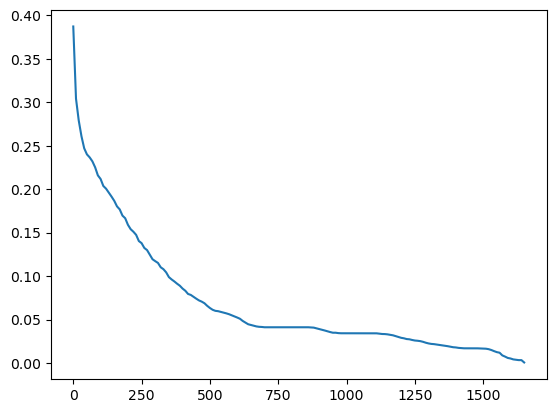

In [68]:
plt.plot([i[0] for i in filter_score_plot_coord], [i[1] for i in filter_score_plot_coord])
plt.show()

In [69]:
vars_keep = filter_score.head(400)

In [70]:
vars_keep

,variable,filter score
256,monthly_income_interact_avg_credit_score,0.387344
259,monthly_income_interact_score_product,0.382134
262,monthly_income_interact_Rank_Order_Scaling_avg...,0.338916
1387,income_tier_interact_Rank_Order_Scaling_avg_cr...,0.337450
1548,score1_percentile_interact_score2_percentile,0.318157
...,...,...
795,credit_line_fraction_interact_disposable_income,0.087207
1061,disposable_income_per_depandent_interact_dispo...,0.086647
625,total_credit_accounts_interact_disposable_income,0.086532
970,disposable_income_interact_credit_score_ratio,0.086068


In [71]:
# filter_score.to_csv('filter_score_brute_force_interaction_smote_under_2_grid.csv')

### Forward Feature Selection

In [72]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, fbeta_score, recall_score, average_precision_score

clf = LGBMClassifier(n_estimators=20, num_leaves=4, random_state=42)

# Define a scorer - here we use average_precision_score 
scorer = make_scorer(average_precision_score, needs_threshold=True)

# Use stratified k-fold to maintain the imbalance ratio in each fold.
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Sequential Forward Selection (SFS)
sfs = SFS(clf,
          k_features=40,  
          forward=True,
          floating=False,
          scoring=scorer,
          cv=cv,
          verbose=True,
          n_jobs=-1)

sfs = sfs.fit(X_resampled[vars_keep['variable'].tolist()], y_resampled)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.3s finished
Features: 1/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 399 out of 399 | elapsed:    4.4s finished
Features: 2/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 351 out of 398 | elapsed:    4.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    4.3s finished
Features: 3/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 conc

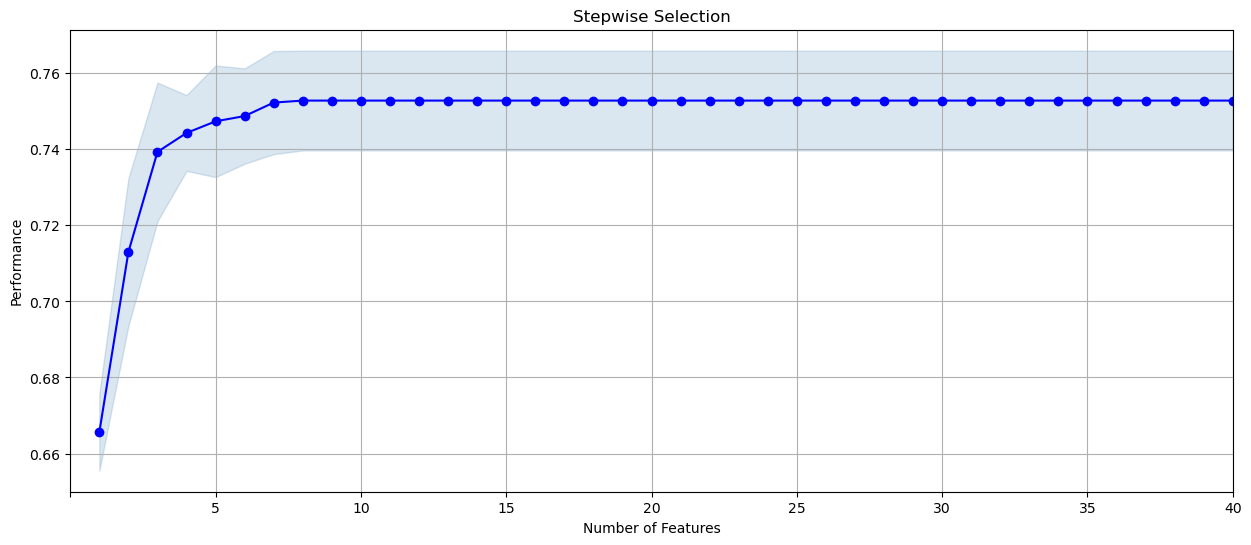

In [73]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X_train[vars_keep['variable'].tolist()]), step=5))
plt.xlim(0,40)
plt.title('Stepwise Selection')
plt.grid()
# plt.savefig('performance_nvars_grid_downsample_2_prauc.png')
plt.show()

In [74]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names']))[0]

# ordered_vars_FS.to_csv('Wrapper_selection_info_SMOTE.csv', index=False)

In [75]:
n_vars_keep = 15
vars_keep_list = list(ordered_vars_FS.loc[n_vars_keep, 'feature_names'])

In [76]:
vars_keep_list

['income_tier',
 'disposable_income_interact_income_tier',
 'credit_line_fraction_interact_income_tier',
 'income_per_credit_line_interact_income_tier',
 'income_tier_interact_household_size',
 'number_open_credit_lines_interact_income_tier',
 'accounts_per_age_interact_income_tier',
 'debt_to_income_ratio_interact_income_tier',
 'avg_credit_score_interact_score1_percentile',
 'score2_interact_score2_percentile',
 'debt_to_income_ratio_interact_Rank_Order_Scaling_avg_credit_score',
 'total_credit_accounts_interact_score1_percentile',
 'norm_credit_score_diff_interact_credit_score_ratio',
 'number_open_loans_interact_score2_percentile',
 'credit_score_ratio']

In [77]:
X_resampled[vars_keep_list]

,income_tier,disposable_income_interact_income_tier,credit_line_fraction_interact_income_tier,income_per_credit_line_interact_income_tier,income_tier_interact_household_size,number_open_credit_lines_interact_income_tier,accounts_per_age_interact_income_tier,debt_to_income_ratio_interact_income_tier,avg_credit_score_interact_score1_percentile,score2_interact_score2_percentile,debt_to_income_ratio_interact_Rank_Order_Scaling_avg_credit_score,total_credit_accounts_interact_score1_percentile,norm_credit_score_diff_interact_credit_score_ratio,number_open_loans_interact_score2_percentile,credit_score_ratio
0,0.503504,895.659272,0.251752,369.235903,0.503504,1.007007,0.040825,0.096386,238.981982,334.165165,0.083164,1.108108,0.063533,0.499499,0.934230
1,0.337337,287.106132,0.224892,78.712045,0.337337,2.698699,0.077306,0.200620,155.034535,489.033033,0.270569,2.609610,0.179459,2.018018,0.797799
2,0.794795,1095.124100,0.550243,198.698699,0.794795,7.153153,0.280516,0.356745,754.301802,521.549550,0.374942,11.567568,0.127454,2.120120,1.120596
3,0.794795,1310.408388,0.496747,331.164498,0.794795,3.973974,0.066233,0.270631,592.078579,69.701702,0.172042,6.176677,0.555284,0.256256,1.466912
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,616.264515,238.878879,0.179189,3.469469,0.293247,0.760761,1.262739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,0.720466,1097.244842,0.480055,192.299807,0.720466,5.755297,0.095244,0.263075,264.979743,296.086941,0.157699,4.516460,0.021297,1.357777,0.977845
5585,0.549831,966.923801,0.395980,203.199336,0.549831,2.839985,0.056677,0.123209,83.310404,274.773583,0.062381,0.925288,0.147653,0.423746,0.855818
5586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,643.921528,160.059013,0.281934,7.272167,0.429595,0.270557,1.371348
5587,0.410467,540.538756,0.284196,160.577811,0.820933,1.863457,0.029637,0.159393,603.091620,82.941779,0.200005,4.847885,0.543261,0.147795,1.457322


In [78]:
X_resampled_mean_1 = X_resampled[vars_keep_list].mean()
X_resampled_std_1 = X_resampled[vars_keep_list].std()

X = (X_resampled[vars_keep_list] - X_resampled_mean_1) / X_resampled_std_1

Clip = 10
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,income_tier,disposable_income_interact_income_tier,credit_line_fraction_interact_income_tier,income_per_credit_line_interact_income_tier,income_tier_interact_household_size,number_open_credit_lines_interact_income_tier,accounts_per_age_interact_income_tier,debt_to_income_ratio_interact_income_tier,avg_credit_score_interact_score1_percentile,score2_interact_score2_percentile,debt_to_income_ratio_interact_Rank_Order_Scaling_avg_credit_score,total_credit_accounts_interact_score1_percentile,norm_credit_score_diff_interact_credit_score_ratio,number_open_loans_interact_score2_percentile,credit_score_ratio
count,5.589000e+03,5589.000000,5.589000e+03,5.589000e+03,5.589000e+03,5.589000e+03,5589.000000,5.589000e+03,5589.000000,5.589000e+03,5589.000000,5.589000e+03,5.589000e+03,5.589000e+03,5.589000e+03
mean,-6.102353e-17,0.000000,-4.068235e-17,-2.034118e-17,4.068235e-17,2.034118e-17,0.000000,-6.102353e-17,0.000000,2.034118e-17,0.000000,-2.034118e-17,1.017059e-17,-2.034118e-17,1.017059e-17
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.284774e+00,-1.105123,-1.186332e+00,-8.919650e-01,-1.018021e+00,-1.039305e+00,-0.957307,-1.123464e+00,-1.418415,-1.351908e+00,-1.697476,-1.263090e+00,-1.254397e+00,-9.399499e-01,-1.864363e+00
25%,-1.284774e+00,-1.105123,-1.186332e+00,-8.919650e-01,-1.018021e+00,-1.039305e+00,-0.957307,-1.123464e+00,-0.889044,-9.065625e-01,-0.745453,-8.176328e-01,-7.292207e-01,-7.717227e-01,-7.517123e-01
50%,-2.090220e-01,-0.164188,-2.685569e-02,-2.342271e-01,-1.636924e-01,-1.765374e-01,-0.204519,-9.594710e-02,-0.147196,-1.655603e-01,-0.164939,-2.186096e-01,-1.966643e-01,-2.888295e-01,-1.014937e-01
75%,7.182956e-01,0.590790,7.259436e-01,3.936304e-01,4.919156e-01,5.671839e-01,0.451757,6.177448e-01,0.800090,8.065519e-01,0.559297,5.941551e-01,4.096715e-01,4.889680e-01,6.726682e-01
max,1.902900e+00,4.365637,3.065602e+00,1.003895e+01,7.554139e+00,5.081226e+00,5.862877,4.538125e+00,2.362463,2.065140e+00,5.016185,6.043977e+00,4.135241e+00,6.064788e+00,2.793196e+00


## Pipeline to Transform X_test

In [79]:
def test_data_transform(x_data):
    
    x = x_data.copy()
    # ---------------------------
    # 1. Credit & Account Features
    # ---------------------------
    # Total Credit Accounts: Sum of open credit lines and open loans
    x['total_credit_accounts'] = x['number_open_credit_lines'] + x['number_open_loans']

    # Binary Flag for Having Both Credit Lines and Loans
    x['has_both_credit_and_loans'] = ((x['number_open_credit_lines'] > 0) & (x['number_open_loans'] > 0)).astype(int)

    # Difference Between Credit Lines and Open Loans
    x['credit_line_loan_diff'] = x['number_open_credit_lines'] - x['number_open_loans']

    # Loan Fraction and Credit Line Fraction
    x['loan_fraction'] = x['number_open_loans'] / (x['total_credit_accounts'] + 1)
    x['credit_line_fraction'] = x['number_open_credit_lines'] / (x['total_credit_accounts'] + 1)

    # Credit Exposure Index: credit_utilization multiplied by total credit accounts
    x['credit_exposure'] = x['credit_utilization'] * x['total_credit_accounts']

    # Credit Accounts per Age: Normalize total accounts by age
    x['accounts_per_age'] = x['total_credit_accounts'] / (x['age'] + 1)

    # ---------------------------
    # 2. Debt & Income Features
    # ---------------------------
    # Estimated Debt Amount: Approximate debt burden = monthly_income * debt_to_income_ratio
    x['estimated_debt'] = x['monthly_income'] * x['debt_to_income_ratio']

    # Estimated Income After Debt: Approximate debt burden = monthly_income * (1 - debt_to_income_ratio)
    x['disposable_income'] = x['monthly_income'] * (1 - x['debt_to_income_ratio'])

    # Debt-to-Income Interaction: Product of debt_to_income_ratio and credit_utilization
    x['dti_credit_util_interaction'] = x['debt_to_income_ratio'] * x['credit_utilization']

    # 
    x['income_per_dependant'] = x['monthly_income'] / (x['number_dependants'] + 1)
    x['disposable_income_per_depandent'] = x['disposable_income'] / (x['number_dependants'] + 1)

    # Income per Credit Account: monthly_income divided by total credit accounts
    # Plus 1 to total_credit_accounts to avoid division errors
    x['income_per_account'] = x['monthly_income'] / (x['total_credit_accounts'] + 1)
    x['income_per_loan'] = x['monthly_income'] / (x['number_open_loans'] + 1)
    x['income_per_credit_line'] = x['monthly_income'] / (x['number_open_credit_lines'] + 1)

    x['disposable_income_per_account'] = x['disposable_income'] / (x['total_credit_accounts'] + 1)
    x['disposable_income_per_loan'] = x['disposable_income'] / (x['number_open_loans'] + 1)
    x['disposable_income_per_credit_line'] = x['disposable_income'] / (x['number_open_credit_lines'] + 1)

    # Debt Pressure Ratio: the ratio of debt obligations to the remaining income
    epsilon = 0.00001  # small constant to avoid division by zero
    x['debt_pressure_ratio'] = x['debt_to_income_ratio'] / (1 - x['debt_to_income_ratio'] + epsilon)

    # Financial Cushion Ratio (inverse of Debt Pressure Ratio)
    x['financial_cushion_ratio'] = (1 - x['debt_to_income_ratio']) / (x['debt_to_income_ratio'] + epsilon)

    # Creating Categorical Variables
    # Debt Tier/Bin: Categorize debt_to_income_ratio into quartiles
    x['debt_tier'] = debt_tier_quantile_transformer.transform(x[['debt_to_income_ratio']])

    # Disposable Income Tier: Categorize disposable income into quartiles
    x['disposable_income_tier'] = disposable_income_quantile_transformer.transform(x[['disposable_income']])

    # Relative Income Rank: Percentile ranking of monthly_income
    x['income_tier'] = income_quantile_transformer.transform(x[['monthly_income']])

    # Debt Burden Relative to Median Income: 
    # Calculate estimated debt and compare it with the median monthly income
    x['debt_to_median_income_ratio'] = (x['monthly_income'] * x['debt_to_income_ratio']) / median_income

    # ---------------------------
    # 3. Dependants & Demographic Features
    # ---------------------------
    # Household Size: Assume the customer is part of the household
    x['household_size'] = x['number_dependants'] + 1

    # Dependants Share: Proportion of household members who are dependants
    x['dependants_share'] = x['number_dependants'] / x['household_size']

    # Dependants-to-Age Ratio: number_dependants divided by age (avoid division by zero)
    x['dependants_to_age'] = x['number_dependants'] / (x['age'] + epsilon)

    # ---------------------------
    # 4. Credit Score Features
    # ---------------------------
    # Average Credit Score: Mean of score1 and score2
    x['avg_credit_score'] = (x['score1'] + x['score2']) / 2

    # Normalized Credit Score Difference: Absolute difference between score1 and score2
    x['norm_credit_score_diff'] = np.abs(x['score1'] - x['score2']) / (x['avg_credit_score'] + epsilon)

    # Credit Score Ratio: Alternative way to assess difference between scoring models
    x['credit_score_ratio'] = x['score1'] / (x['score2'] + epsilon)

    # Score Interaction Term: Product of score1 and score2
    x['score_product'] = x['score1'] * x['score2']

    # Percentile Ranks for Score1 and Score2
    x['score1_percentile'] = score1_quantile_transformer.transform(x[['score1']])
    x['score2_percentile'] = score2_quantile_transformer.transform(x[['score2']])

    # Rank Order Scaling to Combine the Two Scores
    x['Rank_Order_Scaling_avg_credit_score'] = (x['score1_percentile'] + x['score2_percentile']) / 2

    # ---------------------------
    # 5. Repayment History and Delinquency
    # ---------------------------
    # Delinquency Flags: Create binary features for any 90 days past due or charged off events
    x['flag_90_days_past_due'] = (x['number_90_days_past_due'] > 0).astype(int)
    x['flag_charged_off'] = (x['number_charged_off'] > 0).astype(int)

    # Aggregate Delinquency Score: Sum of number_90_days_past_due and number_charged_off
    x['aggregate_delinquency'] = x['number_90_days_past_due'] + x['number_charged_off']

    # Weighted Delinquency Score: Charged-offs are weighted more heavily
    x['weighted_delinquency'] = x['number_90_days_past_due'] + 2 * x['number_charged_off']

    # Delinquency Ratios: Normalize delinquency counts by total credit accounts
    x['ratio_90_days_to_total_accounts'] = x['number_90_days_past_due'] / (x['total_credit_accounts'] + 1)
    x['ratio_charged_off_to_total_accounts'] = x['number_charged_off'] / (x['total_credit_accounts'] + 1)

    # Delinquency Ratio per Loan: Normalize past due events by the number of open loans
    x['past_due_rate'] = x['number_90_days_past_due'] / (x['number_open_loans'] + 1)

    # Aggregate Delinquency per Credit Account: Normalize total delinquency events by total credit accounts
    x['delinquency_per_account'] = (x['number_90_days_past_due'] + x['number_charged_off']) / (x['total_credit_accounts'] + 1)

    # Delinquency Impact Score: Combine weighted delinquency with the debt-to-income ratio
    x['delinquency_impact'] = x['weighted_delinquency'] * x['debt_to_income_ratio']

    # Chronic Delinquency Flag: Flag customers with more than 1 event (either past due or charged off)
    x['chronic_delinquency'] = ((x['number_90_days_past_due'] > 1) | (x['number_charged_off'] > 1)).astype(int)

    # Delinquency Exposure Relative to Age: Normalize aggregate delinquency by age
    x['delinquency_exposure'] = (x['number_90_days_past_due'] + x['number_charged_off']) / (x['age'] + epsilon)

    # Delinquency-Credit Utilization Interaction: Interaction between delinquency and credit utilization
    x['delinquency_util_interaction'] = (x['number_90_days_past_due'] + x['number_charged_off']) * x['credit_utilization']

    # ---------------------------
    # 6. Interaction Features
    # ---------------------------
    cur_column_list = list(x.columns)
    for i in range(len(cur_column_list)):
        j = i + 1
        while j < len(cur_column_list):
            cur_string = str(cur_column_list[i]) + '_interact_' + str(cur_column_list[j])
            x[cur_string] = x[cur_column_list[i]] * x[cur_column_list[j]]
            j += 1
    
    return x

In [80]:
x_test_trans = test_data_transform(X_test)
X_test_transformed = (x_test_trans[vars_keep_list] - X_resampled_mean_1) / X_resampled_std_1
X_test_transformed.clip(-1*Clip, Clip, inplace=True)

## Test Multiple Models, Grid Search and Model Selection

Since the way the features are engineered could lead to serious multicollinearity and conducting PCA could further make models less interpretable, multiple tree-based models with different hyperparameters are tested and tuned with grid-search and a consistent evaluation framework using cross-validation and a threshold-independent scoring metric (average_precision_score, which is an proxy to PR AUC) to compare different models fairly is built. This ensures that each candidate is optimized and assessed on the same grounds. The candidates of models include LightGBM, RandomForest, XGBoost. A detailed result from the entire grid-search process is saved, including model's name, model's parameters, mean training average_precision_score, mean testing average_precision_score, difference between mean training average_precision_score and mean testing average_precision_score.

Ultimately, a LightGBM model with n_estimators=40, num_leaves=4, learning_rate=0.1, random_state=42 is selected because of its relatively high mean testing average_precision_score (0.7585) and its relatively low difference between mean training average_precision_score and mean testing average_precision_score (0.0143). The model has an actual PR AUC of 0.7731. After moving around cut-off point for the record to be regarded as will default using sorted predict_proba, the cut-off point is set to be 0.4, which means that a record with predict_proba > 0.4 will be regarded as will default, and it is estimated that with this cut-off point, the model will tag 40.3% applications as will default, and has a recall of 0.7707, which means that the model can successfully catch 77.07% of the applications that will default.

In [81]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

In [82]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Define a scorer using average precision (PR-AUC) that requires predicted probabilities
pr_auc_scorer = make_scorer(average_precision_score, needs_threshold=True)

# Use StratifiedKFold for robust cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define models
models = {
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# seems the model can get too complex -> overfit
# Define parameter grids for each model
# param_grids = {
#     'LightGBM': {
#         'n_estimators': [20, 50, 100, 150, 200, 250, 300, 350],
#         'max_depth': [-1, 10, 15, 20, 25],
#         'learning_rate': [0.01, 0.1]
#     }, 
#     'RandomForest': {
#         'n_estimators': [200, 250, 300, 350, 400, 450],
#         'max_depth': [None, 10, 15, 20, 25]
#     },
#     'XGBoost': {
#         'n_estimators': [20, 50, 100, 150, 200, 250, 300, 350],
#         'max_depth': [None, 10, 15, 20, 25],
#         'learning_rate': [0.01, 0.1]
#     },
#     'GradientBoosting':
#     {
#         'n_estimators': [20, 50, 100, 150, 200, 250, 300, 350],
#         'max_depth': [None, 10, 15, 20, 25],
#         'learning_rate': [0.01, 0.1]
#     },
# }

param_grids = {
    'LightGBM': {
'n_estimators': np.arange(20,150,20),
'num_leaves': [2**i for i in range(2,7)] + [None],
'learning_rate': [None, 0.01, 0.1]
    }, 
    'RandomForest': {
        'n_estimators': np.arange(20,150,20),
        'max_depth': [None, 3, 5, 10, 15, 20],
    },
    'XGBoost': {
        'n_estimators': np.arange(20,150,20),
        'num_leaves': [2**i for i in range(2,7)] + [None],
        'learning_rate': [None, 0.01, 0.1]
    },
    'GradientBoosting':
    {
        'n_estimators': np.arange(20,150,20),
        'max_depth': [None, 3, 5, 10, 15, 20],
        'learning_rate': [None, 0.01, 0.1]
    },
}

# Create an empty list to store detailed results
detailed_results = []
grid_search_result_df = pd.DataFrame()
# Loop over each model and conduct grid search
for model_name, model in models.items():
    print(f"\nRunning grid search for {model_name}...")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grids[model_name],
                               scoring=pr_auc_scorer,
                               cv=cv,
                               n_jobs=-1,
                               verbose=10,
                               return_train_score=True)
    grid_search.fit(X, y_resampled)
    
    # Loop over all parameter combinations from cv_results_ to record the mean test score (PR-AUC)
    for mean_score, params in zip(grid_search.cv_results_['mean_test_score'],
                                  grid_search.cv_results_['params']):
        detailed_results.append({
            'Model': model_name,
            'Parameters': params,
            'PR_AUC': mean_score
        })
    
    cv_result = pd.DataFrame(grid_search.cv_results_)
    cv_result['model_name'] = model_name
    grid_search_result_df = pd.concat([grid_search_result_df, cv_result])
        
    print(f"Best PR-AUC for {model_name}: {grid_search.best_score_:.4f}")
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

# Convert the detailed results to a DataFrame and sort by PR_AUC score (descending)
results_df = pd.DataFrame(detailed_results)
results_df = results_df.sort_values(by='PR_AUC', ascending=False).reset_index(drop=True)





Running grid search for LightGBM...
Fitting 4 folds for each of 126 candidates, totalling 504 fits
[LightGBM] [Info] Number of positive: 2395, number of negative: 3194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3779
[LightGBM] [Info] Number of data points in the train set: 5589, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428520 -> initscore=-0.287891
[LightGBM] [Info] Start training from score -0.287891
Best PR-AUC for LightGBM: 0.7827
Best Parameters for LightGBM: {'learning_rate': None, 'n_estimators': 100, 'num_leaves': 16}

Running grid search for RandomForest...
Fitting 4 folds for each of 42 candidates, totalling 168 fits
Best PR-AUC for RandomForest: 0.7642
Best Parameters for RandomForest: {'max_depth': 15, 'n_estimators': 140}

Running grid search for XGBoost...
Fitting 4 folds for each of 126 ca

In [83]:
grid_search_result_df['mean_train_test_score_diff'] = abs(grid_search_result_df['mean_train_score'] - grid_search_result_df['mean_test_score'])
grid_search_result_df = grid_search_result_df.sort_values(by=['mean_train_test_score_diff','mean_test_score', 'mean_train_score'], ascending=[True, False, False])
# grid_search_result_df.to_csv('detailed_grid_search_result_smote_075_downsample_2.csv')


In [84]:
grid_search_result_df[['model_name','mean_test_score', 'mean_train_score', 'mean_train_test_score_diff', 'params']].head(30)

,model_name,mean_test_score,mean_train_score,mean_train_test_score_diff,params
0,LightGBM,0.746304,0.758493,0.012189,"{'learning_rate': None, 'n_estimators': 20, 'n..."
84,LightGBM,0.746304,0.758493,0.012189,"{'learning_rate': 0.1, 'n_estimators': 20, 'nu..."
42,LightGBM,0.628532,0.641443,0.012910,"{'learning_rate': 0.01, 'n_estimators': 20, 'n..."
78,LightGBM,0.741004,0.754884,0.013880,"{'learning_rate': 0.01, 'n_estimators': 140, '..."
72,LightGBM,0.735610,0.749520,0.013909,"{'learning_rate': 0.01, 'n_estimators': 120, '..."
66,LightGBM,0.725716,0.740789,0.015073,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
60,LightGBM,0.715421,0.730669,0.015248,"{'learning_rate': 0.01, 'n_estimators': 80, 'n..."
48,LightGBM,0.659852,0.675261,0.015409,"{'learning_rate': 0.01, 'n_estimators': 40, 'n..."
53,GradientBoosting,0.740921,0.758447,0.017526,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
54,LightGBM,0.690008,0.707629,0.017621,"{'learning_rate': 0.01, 'n_estimators': 60, 'n..."


In [85]:
grid_search_result_df[['model_name','mean_test_score', 'mean_train_score', 'mean_train_test_score_diff', 'params']].iloc[0,-1]

{'learning_rate': None, 'n_estimators': 20, 'num_leaves': 4}

In [86]:
best_clf = lgb.LGBMClassifier(n_estimators=20, num_leaves=4, learning_rate=0.1, random_state=42)

best_clf.fit(X, y_resampled)

from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Example true labels and predicted probabilities
y_scores = best_clf.predict_proba(X)

# Calculate precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_resampled, y_scores[:,1])

# Calculate the PR AUC
pr_auc = auc(recall, precision)

print(f"PR AUC: {pr_auc}")

score_board = pd.DataFrame({
    'target': y_resampled,
    'scores': y_scores[:,1]
})

score_board = score_board.sort_values(by=['scores'], ascending=False)


[LightGBM] [Info] Number of positive: 2395, number of negative: 3194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3779
[LightGBM] [Info] Number of data points in the train set: 5589, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428520 -> initscore=-0.287891
[LightGBM] [Info] Start training from score -0.287891
PR AUC: 0.7667527483128375


In [87]:
stats = []
for tr in np.arange(0,1,0.025):
    tr = 1-tr
    prob_bad = len(score_board[score_board['scores'] > tr])
    prob_tp = len(score_board[(score_board['scores'] > tr) & (score_board['target'] == 1)])
    stats.append([tr, 
                  prob_bad, 
                  prob_tp, 
                  prob_bad / len(score_board), 
                  prob_tp / sum(score_board['target'])])


In [88]:
pd.DataFrame(stats, columns=['predict_proba cut off point', 'number of predicted default', 'number of actual default', 'percentage of default predicted', 'percentage of actual default caught'])

,predict_proba cut off point,number of predicted default,number of actual default,percentage of default predicted,percentage of actual default caught
0,1.000,0,0,0.000000,0.000000
1,0.975,0,0,0.000000,0.000000
2,0.950,0,0,0.000000,0.000000
3,0.925,0,0,0.000000,0.000000
4,0.900,0,0,0.000000,0.000000
5,0.875,0,0,0.000000,0.000000
6,0.850,0,0,0.000000,0.000000
7,0.825,0,0,0.000000,0.000000
8,0.800,0,0,0.000000,0.000000
9,0.775,17,17,0.003042,0.007098


In [89]:
y_pred_test1 = best_clf.predict_proba(X_test_transformed)[:,-1]

y_pred_test_all = pd.DataFrame({
    'target': y_test,
    'scores': y_pred_test1
})


In [90]:
stats_test = []
for tr in np.arange(0,1,0.025):
    tr = 1-tr
    prob_bad = len(y_pred_test_all[y_pred_test_all['scores'] > tr])
    prob_tp = len(y_pred_test_all[(y_pred_test_all['scores'] > tr) & (y_pred_test_all['target'] == 1)])
    stats_test.append([tr, 
                  prob_bad, 
                  prob_tp, 
                  prob_bad / len(y_pred_test_all), 
                  prob_tp / sum(y_pred_test_all['target'])])


In [91]:
pd.DataFrame(stats_test, columns=['predict_proba cut off point', 'number of predicted default', 'number of actual default', 'percentage of default predicted', 'percentage of actual default caught'])

,predict_proba cut off point,number of predicted default,number of actual default,percentage of default predicted,percentage of actual default caught
0,1.000,0,0,0.000000,0.000000
1,0.975,0,0,0.000000,0.000000
2,0.950,0,0,0.000000,0.000000
3,0.925,0,0,0.000000,0.000000
4,0.900,0,0,0.000000,0.000000
5,0.875,0,0,0.000000,0.000000
6,0.850,0,0,0.000000,0.000000
7,0.825,0,0,0.000000,0.000000
8,0.800,0,0,0.000000,0.000000
9,0.775,0,0,0.000000,0.000000


In [92]:
loan_default_predict_proba_threshold = 0.4

In [93]:
y_pred_test_all['pred_outcome'] = y_pred_test_all['scores'].apply(lambda x: 0 if x < loan_default_predict_proba_threshold else 1)


In [94]:
print(y_pred_test_all[y_pred_test_all['pred_outcome'] == 1]['target'].value_counts())


target
0    1701
1     410
Name: count, dtype: int64


In [95]:
clf_recall = len(y_pred_test_all[(y_pred_test_all['pred_outcome'] == 1) & (y_pred_test_all['target'] == 1)]) / len(y_pred_test_all[y_pred_test_all['target'] == 1])
clf_precision = len(y_pred_test_all[(y_pred_test_all['pred_outcome'] == 1) & (y_pred_test_all['target'] == 1)]) / len(y_pred_test_all[y_pred_test_all['pred_outcome'] == 1])
clf_proportion_bad = len(y_pred_test_all[y_pred_test_all['pred_outcome'] == 1]) / len(y_pred_test_all)

In [96]:
clf_recall

0.7706766917293233

In [97]:
clf_precision

0.1942207484604453

In [98]:
clf_proportion_bad

0.4051823416506718

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

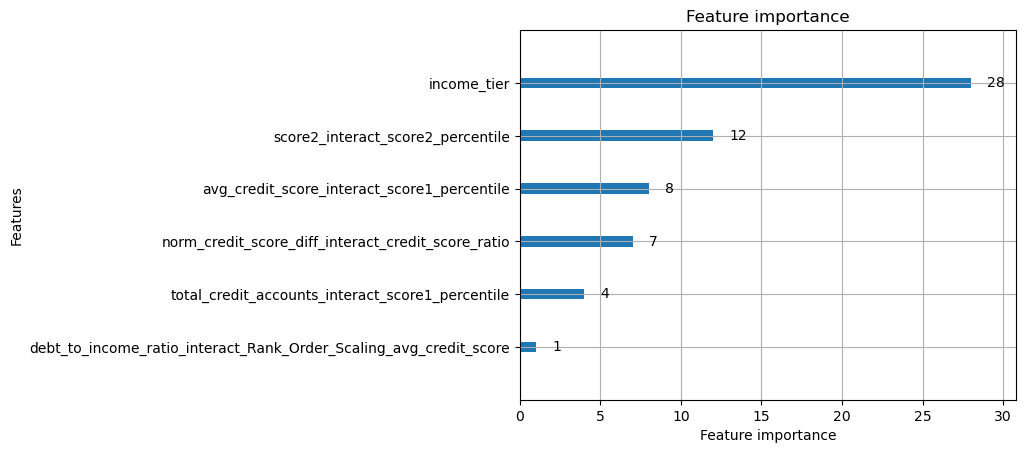

In [99]:
lgb.plot_importance(best_clf)

In [100]:
vars_keep_list

['income_tier',
 'disposable_income_interact_income_tier',
 'credit_line_fraction_interact_income_tier',
 'income_per_credit_line_interact_income_tier',
 'income_tier_interact_household_size',
 'number_open_credit_lines_interact_income_tier',
 'accounts_per_age_interact_income_tier',
 'debt_to_income_ratio_interact_income_tier',
 'avg_credit_score_interact_score1_percentile',
 'score2_interact_score2_percentile',
 'debt_to_income_ratio_interact_Rank_Order_Scaling_avg_credit_score',
 'total_credit_accounts_interact_score1_percentile',
 'norm_credit_score_diff_interact_credit_score_ratio',
 'number_open_loans_interact_score2_percentile',
 'credit_score_ratio']

## Finally, Retrain the Model with Exact Same Steps and Combinations of Parameters on the Whole Dataset

In [101]:
X_whole = df.drop(columns=['target'])
y_whole = df['target']

In [102]:
# ---------------------------
# 1. Credit & Account Features
# ---------------------------
# Total Credit Accounts: Sum of open credit lines and open loans
X_whole['total_credit_accounts'] = X_whole['number_open_credit_lines'] + X_whole['number_open_loans']

# Binary Flag for Having Both Credit Lines and Loans
X_whole['has_both_credit_and_loans'] = ((X_whole['number_open_credit_lines'] > 0) & (X_whole['number_open_loans'] > 0)).astype(int)

# Difference Between Credit Lines and Open Loans
X_whole['credit_line_loan_diff'] = X_whole['number_open_credit_lines'] - X_whole['number_open_loans']

# Loan Fraction and Credit Line Fraction
X_whole['loan_fraction'] = X_whole['number_open_loans'] / (X_whole['total_credit_accounts'] + 1)
X_whole['credit_line_fraction'] = X_whole['number_open_credit_lines'] / (X_whole['total_credit_accounts'] + 1)

# Credit Exposure Index: credit_utilization multiplied by total credit accounts
X_whole['credit_exposure'] = X_whole['credit_utilization'] * X_whole['total_credit_accounts']

# Credit Accounts per Age: Normalize total accounts by age
X_whole['accounts_per_age'] = X_whole['total_credit_accounts'] / (X_whole['age'] + 1)

# ---------------------------
# 2. Debt & Income Features
# ---------------------------
# Estimated Debt Amount: Approximate debt burden = monthly_income * debt_to_income_ratio
X_whole['estimated_debt'] = X_whole['monthly_income'] * X_whole['debt_to_income_ratio']

# Estimated Income After Debt: Approximate debt burden = monthly_income * (1 - debt_to_income_ratio)
X_whole['disposable_income'] = X_whole['monthly_income'] * (1 - X_whole['debt_to_income_ratio'])

# Debt-to-Income Interaction: Product of debt_to_income_ratio and credit_utilization
X_whole['dti_credit_util_interaction'] = X_whole['debt_to_income_ratio'] * X_whole['credit_utilization']

# 
X_whole['income_per_dependant'] = X_whole['monthly_income'] / (X_whole['number_dependants'] + 1)
X_whole['disposable_income_per_depandent'] = X_whole['disposable_income'] / (X_whole['number_dependants'] + 1)

# Income per Credit Account: monthly_income divided by total credit accounts
# Plus 1 to total_credit_accounts to avoid division errors
X_whole['income_per_account'] = X_whole['monthly_income'] / (X_whole['total_credit_accounts'] + 1)
X_whole['income_per_loan'] = X_whole['monthly_income'] / (X_whole['number_open_loans'] + 1)
X_whole['income_per_credit_line'] = X_whole['monthly_income'] / (X_whole['number_open_credit_lines'] + 1)

X_whole['disposable_income_per_account'] = X_whole['disposable_income'] / (X_whole['total_credit_accounts'] + 1)
X_whole['disposable_income_per_loan'] = X_whole['disposable_income'] / (X_whole['number_open_loans'] + 1)
X_whole['disposable_income_per_credit_line'] = X_whole['disposable_income'] / (X_whole['number_open_credit_lines'] + 1)

# Debt Pressure Ratio: the ratio of debt obligations to the remaining income
epsilon = 0.00001  # small constant to avoid division by zero
X_whole['debt_pressure_ratio'] = X_whole['debt_to_income_ratio'] / (1 - X_whole['debt_to_income_ratio'] + epsilon)

# Financial Cushion Ratio (inverse of Debt Pressure Ratio)
X_whole['financial_cushion_ratio'] = (1 - X_whole['debt_to_income_ratio']) / (X_whole['debt_to_income_ratio'] + epsilon)

# Creating Categorical Variables
# Debt Tier/Bin: Categorize debt_to_income_ratio into quartiles
debt_tier_quantile_transformer_whole = QuantileTransformer(n_quantiles=min(1000, len(X_whole)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_whole['debt_tier'] = debt_tier_quantile_transformer_whole.fit_transform(X_whole[['debt_to_income_ratio']])

# Disposable Income Tier: Categorize disposable income into quartiles
disposable_income_quantile_transformer_whole = QuantileTransformer(n_quantiles=min(1000, len(X_whole)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_whole['disposable_income_tier'] = disposable_income_quantile_transformer_whole.fit_transform(X_whole[['disposable_income']])

# Relative Income Rank: Percentile ranking of monthly_income
income_quantile_transformer_whole = QuantileTransformer(n_quantiles=min(1000, len(X_whole)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_whole['income_tier'] = income_quantile_transformer_whole.fit_transform(X_whole[['monthly_income']])

# Debt Burden Relative to Median Income: 
# Calculate estimated debt and compare it with the median monthly income
median_income = X_whole['monthly_income'].median()
X_whole['debt_to_median_income_ratio'] = (X_whole['monthly_income'] * X_whole['debt_to_income_ratio']) / median_income

# ---------------------------
# 3. Dependants & Demographic Features
# ---------------------------
# Household Size: Assume the customer is part of the household
X_whole['household_size'] = X_whole['number_dependants'] + 1

# Dependants Share: Proportion of household members who are dependants
X_whole['dependants_share'] = X_whole['number_dependants'] / X_whole['household_size']

# Dependants-to-Age Ratio: number_dependants divided by age (avoid division by zero)
X_whole['dependants_to_age'] = X_whole['number_dependants'] / (X_whole['age'] + epsilon)

# ---------------------------
# 4. Credit Score Features
# ---------------------------
# Average Credit Score: Mean of score1 and score2
X_whole['avg_credit_score'] = (X_whole['score1'] + X_whole['score2']) / 2

# Normalized Credit Score Difference: Absolute difference between score1 and score2
X_whole['norm_credit_score_diff'] = np.abs(X_whole['score1'] - X_whole['score2']) / (X_whole['avg_credit_score'] + epsilon)

# Credit Score Ratio: Alternative way to assess difference between scoring models
X_whole['credit_score_ratio'] = X_whole['score1'] / (X_whole['score2'] + epsilon)

# Score Interaction Term: Product of score1 and score2
X_whole['score_product'] = X_whole['score1'] * X_whole['score2']

# Percentile Ranks for Score1 and Score2
score1_quantile_transformer_whole = QuantileTransformer(n_quantiles=min(1000, len(X_whole)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_whole['score1_percentile'] = score1_quantile_transformer_whole.fit_transform(X_whole[['score1']])

score2_quantile_transformer_whole = QuantileTransformer(n_quantiles=min(1000, len(X_whole)), 
                                           output_distribution='uniform', 
                                           random_state=42)
X_whole['score2_percentile'] = score2_quantile_transformer_whole.fit_transform(X_whole[['score2']])

# Rank Order Scaling to Combine the Two Scores
X_whole['Rank_Order_Scaling_avg_credit_score'] = (X_whole['score1_percentile'] + X_whole['score2_percentile']) / 2

# ---------------------------
# 5. Repayment History and Delinquency
# ---------------------------
# Delinquency Flags: Create binary features for any 90 days past due or charged off events
X_whole['flag_90_days_past_due'] = (X_whole['number_90_days_past_due'] > 0).astype(int)
X_whole['flag_charged_off'] = (X_whole['number_charged_off'] > 0).astype(int)

# Aggregate Delinquency Score: Sum of number_90_days_past_due and number_charged_off
X_whole['aggregate_delinquency'] = X_whole['number_90_days_past_due'] + X_whole['number_charged_off']

# Weighted Delinquency Score: Charged-offs are weighted more heavily
X_whole['weighted_delinquency'] = X_whole['number_90_days_past_due'] + 2 * X_whole['number_charged_off']

# Delinquency Ratios: Normalize delinquency counts by total credit accounts
X_whole['ratio_90_days_to_total_accounts'] = X_whole['number_90_days_past_due'] / (X_whole['total_credit_accounts'] + 1)
X_whole['ratio_charged_off_to_total_accounts'] = X_whole['number_charged_off'] / (X_whole['total_credit_accounts'] + 1)

# Delinquency Ratio per Loan: Normalize past due events by the number of open loans
X_whole['past_due_rate'] = X_whole['number_90_days_past_due'] / (X_whole['number_open_loans'] + 1)

# Aggregate Delinquency per Credit Account: Normalize total delinquency events by total credit accounts
X_whole['delinquency_per_account'] = (X_whole['number_90_days_past_due'] + X_whole['number_charged_off']) / (X_whole['total_credit_accounts'] + 1)

# Delinquency Impact Score: Combine weighted delinquency with the debt-to-income ratio
X_whole['delinquency_impact'] = X_whole['weighted_delinquency'] * X_whole['debt_to_income_ratio']

# Chronic Delinquency Flag: Flag customers with more than 1 event (either past due or charged off)
X_whole['chronic_delinquency'] = ((X_whole['number_90_days_past_due'] > 1) | (X_whole['number_charged_off'] > 1)).astype(int)

# Delinquency Exposure Relative to Age: Normalize aggregate delinquency by age
X_whole['delinquency_exposure'] = (X_whole['number_90_days_past_due'] + X_whole['number_charged_off']) / (X_whole['age'] + epsilon)

# Delinquency-Credit Utilization Interaction: Interaction between delinquency and credit utilization
X_whole['delinquency_util_interaction'] = (X_whole['number_90_days_past_due'] + X_whole['number_charged_off']) * X_whole['credit_utilization']

# ---------------------------
# 6. Interaction Features
# ---------------------------
cur_column_list = list(X_whole.columns)
for i in range(len(cur_column_list)):
    j = i + 1
    while j < len(cur_column_list):
        cur_string = str(cur_column_list[i]) + '_interact_' + str(cur_column_list[j])
        X_whole[cur_string] = X_whole[cur_column_list[i]] * X_whole[cur_column_list[j]]
        j += 1

In [103]:
X_whole[vars_keep_list].corr()

,income_tier,disposable_income_interact_income_tier,credit_line_fraction_interact_income_tier,income_per_credit_line_interact_income_tier,income_tier_interact_household_size,number_open_credit_lines_interact_income_tier,accounts_per_age_interact_income_tier,debt_to_income_ratio_interact_income_tier,avg_credit_score_interact_score1_percentile,score2_interact_score2_percentile,debt_to_income_ratio_interact_Rank_Order_Scaling_avg_credit_score,total_credit_accounts_interact_score1_percentile,norm_credit_score_diff_interact_credit_score_ratio,number_open_loans_interact_score2_percentile,credit_score_ratio
income_tier,1.000000,0.940293,0.905900,0.731341,0.770825,0.786754,0.713628,0.850243,-0.007722,-0.003578,-0.006075,-0.002301,0.002121,-0.002269,-0.001102
disposable_income_interact_income_tier,0.940293,1.000000,0.852734,0.720020,0.726857,0.741235,0.671807,0.655760,-0.007370,-0.004943,-0.141996,-0.001134,0.004217,-0.006795,0.000796
credit_line_fraction_interact_income_tier,0.905900,0.852734,1.000000,0.461464,0.698176,0.890240,0.691300,0.768293,-0.000455,-0.000206,-0.005461,0.043976,0.003378,-0.160323,0.001330
income_per_credit_line_interact_income_tier,0.731341,0.720020,0.461464,1.000000,0.563513,0.254937,0.318255,0.620290,-0.010668,-0.007703,-0.007728,-0.184915,0.006181,-0.001077,0.000384
income_tier_interact_household_size,0.770825,0.726857,0.698176,0.563513,1.000000,0.606614,0.550741,0.653568,-0.009977,0.001117,-0.005159,-0.005328,-0.001161,-0.000334,-0.006842
number_open_credit_lines_interact_income_tier,0.786754,0.741235,0.890240,0.254937,0.606614,1.000000,0.805368,0.666031,0.005484,-0.001484,-0.003181,0.232143,0.007955,-0.001522,0.007078
accounts_per_age_interact_income_tier,0.713628,0.671807,0.691300,0.318255,0.550741,0.805368,1.000000,0.606093,-0.004261,0.001749,-0.003125,0.201587,0.005225,0.151878,-0.002081
debt_to_income_ratio_interact_income_tier,0.850243,0.655760,0.768293,0.620290,0.653568,0.666031,0.606093,1.000000,-0.003245,-0.001819,0.267469,-0.000481,0.000298,0.005299,-0.000477
avg_credit_score_interact_score1_percentile,-0.007722,-0.007370,-0.000455,-0.010668,-0.009977,0.005484,-0.004261,-0.003245,1.000000,0.123756,0.581368,0.788717,0.179546,0.070460,0.593629
score2_interact_score2_percentile,-0.003578,-0.004943,-0.000206,-0.007703,0.001117,-0.001484,0.001749,-0.001819,0.123756,1.000000,0.515611,0.008094,-0.332254,0.568807,-0.692180


In [104]:
# Downsample
X_whole['target'] = y_whole

print(X_whole.shape)

X_whole_ds_neg = X_whole[X_whole['target'] == 0].sample(n=len(X_whole[X_whole['target'] == 1]) * 2,random_state=42)
X_whole_ds_pos = X_whole[X_whole['target'] == 1]

X_whole_resampled = pd.concat([X_whole_ds_neg, X_whole_ds_pos])
y_whole_resampled = X_whole_resampled['target']
X_whole_resampled = X_whole_resampled.drop(columns=['target'])
print(X_whole_resampled.shape)

from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.75) 
X_whole_resampled, y_whole_resampled = smote.fit_resample(X_whole_resampled, y_whole_resampled)
print(X_whole_resampled.shape)

(20839, 1654)
(6387, 1653)
(7451, 1653)


In [105]:
X_whole_resampled_mean_1 = X_whole_resampled[vars_keep_list].mean()
X_whole_resampled_std_1 = X_whole_resampled[vars_keep_list].std()

X_whole_resampled = (X_whole_resampled[vars_keep_list] - X_whole_resampled_mean_1) / X_whole_resampled_std_1

Clip = 10
# push in any outlier values, then rescale
X_whole_resampled.clip(-1*Clip,Clip,inplace=True)
X_whole_resampled = (X_whole_resampled - X_whole_resampled.mean()) / X_whole_resampled.std()

In [106]:
def submission_data_transform(x_data):
    
    x = x_data.copy()
    # ---------------------------
    # 1. Credit & Account Features
    # ---------------------------
    # Total Credit Accounts: Sum of open credit lines and open loans
    x['total_credit_accounts'] = x['number_open_credit_lines'] + x['number_open_loans']

    # Binary Flag for Having Both Credit Lines and Loans
    x['has_both_credit_and_loans'] = ((x['number_open_credit_lines'] > 0) & (x['number_open_loans'] > 0)).astype(int)

    # Difference Between Credit Lines and Open Loans
    x['credit_line_loan_diff'] = x['number_open_credit_lines'] - x['number_open_loans']

    # Loan Fraction and Credit Line Fraction
    x['loan_fraction'] = x['number_open_loans'] / (x['total_credit_accounts'] + 1)
    x['credit_line_fraction'] = x['number_open_credit_lines'] / (x['total_credit_accounts'] + 1)

    # Credit Exposure Index: credit_utilization multiplied by total credit accounts
    x['credit_exposure'] = x['credit_utilization'] * x['total_credit_accounts']

    # Credit Accounts per Age: Normalize total accounts by age
    x['accounts_per_age'] = x['total_credit_accounts'] / (x['age'] + 1)

    # ---------------------------
    # 2. Debt & Income Features
    # ---------------------------
    # Estimated Debt Amount: Approximate debt burden = monthly_income * debt_to_income_ratio
    x['estimated_debt'] = x['monthly_income'] * x['debt_to_income_ratio']

    # Estimated Income After Debt: Approximate debt burden = monthly_income * (1 - debt_to_income_ratio)
    x['disposable_income'] = x['monthly_income'] * (1 - x['debt_to_income_ratio'])

    # Debt-to-Income Interaction: Product of debt_to_income_ratio and credit_utilization
    x['dti_credit_util_interaction'] = x['debt_to_income_ratio'] * x['credit_utilization']

    # 
    x['income_per_dependant'] = x['monthly_income'] / (x['number_dependants'] + 1)
    x['disposable_income_per_depandent'] = x['disposable_income'] / (x['number_dependants'] + 1)

    # Income per Credit Account: monthly_income divided by total credit accounts
    # Plus 1 to total_credit_accounts to avoid division errors
    x['income_per_account'] = x['monthly_income'] / (x['total_credit_accounts'] + 1)
    x['income_per_loan'] = x['monthly_income'] / (x['number_open_loans'] + 1)
    x['income_per_credit_line'] = x['monthly_income'] / (x['number_open_credit_lines'] + 1)

    x['disposable_income_per_account'] = x['disposable_income'] / (x['total_credit_accounts'] + 1)
    x['disposable_income_per_loan'] = x['disposable_income'] / (x['number_open_loans'] + 1)
    x['disposable_income_per_credit_line'] = x['disposable_income'] / (x['number_open_credit_lines'] + 1)

    # Debt Pressure Ratio: the ratio of debt obligations to the remaining income
    epsilon = 0.00001  # small constant to avoid division by zero
    x['debt_pressure_ratio'] = x['debt_to_income_ratio'] / (1 - x['debt_to_income_ratio'] + epsilon)

    # Financial Cushion Ratio (inverse of Debt Pressure Ratio)
    x['financial_cushion_ratio'] = (1 - x['debt_to_income_ratio']) / (x['debt_to_income_ratio'] + epsilon)

    # Creating Categorical Variables
    # Debt Tier/Bin: Categorize debt_to_income_ratio into quartiles
    x['debt_tier'] = debt_tier_quantile_transformer_whole.transform(x[['debt_to_income_ratio']])

    # Disposable Income Tier: Categorize disposable income into quartiles
    x['disposable_income_tier'] = disposable_income_quantile_transformer_whole.transform(x[['disposable_income']])

    # Relative Income Rank: Percentile ranking of monthly_income
    x['income_tier'] = income_quantile_transformer_whole.transform(x[['monthly_income']])

    # Debt Burden Relative to Median Income: 
    # Calculate estimated debt and compare it with the median monthly income
    x['debt_to_median_income_ratio'] = (x['monthly_income'] * x['debt_to_income_ratio']) / median_income

    # ---------------------------
    # 3. Dependants & Demographic Features
    # ---------------------------
    # Household Size: Assume the customer is part of the household
    x['household_size'] = x['number_dependants'] + 1

    # Dependants Share: Proportion of household members who are dependants
    x['dependants_share'] = x['number_dependants'] / x['household_size']

    # Dependants-to-Age Ratio: number_dependants divided by age (avoid division by zero)
    x['dependants_to_age'] = x['number_dependants'] / (x['age'] + epsilon)

    # ---------------------------
    # 4. Credit Score Features
    # ---------------------------
    # Average Credit Score: Mean of score1 and score2
    x['avg_credit_score'] = (x['score1'] + x['score2']) / 2

    # Normalized Credit Score Difference: Absolute difference between score1 and score2
    x['norm_credit_score_diff'] = np.abs(x['score1'] - x['score2']) / (x['avg_credit_score'] + epsilon)

    # Credit Score Ratio: Alternative way to assess difference between scoring models
    x['credit_score_ratio'] = x['score1'] / (x['score2'] + epsilon)

    # Score Interaction Term: Product of score1 and score2
    x['score_product'] = x['score1'] * x['score2']

    # Percentile Ranks for Score1 and Score2
    x['score1_percentile'] = score1_quantile_transformer_whole.transform(x[['score1']])
    x['score2_percentile'] = score2_quantile_transformer_whole.transform(x[['score2']])

    # Rank Order Scaling to Combine the Two Scores
    x['Rank_Order_Scaling_avg_credit_score'] = (x['score1_percentile'] + x['score2_percentile']) / 2

    # ---------------------------
    # 5. Repayment History and Delinquency
    # ---------------------------
    # Delinquency Flags: Create binary features for any 90 days past due or charged off events
    x['flag_90_days_past_due'] = (x['number_90_days_past_due'] > 0).astype(int)
    x['flag_charged_off'] = (x['number_charged_off'] > 0).astype(int)

    # Aggregate Delinquency Score: Sum of number_90_days_past_due and number_charged_off
    x['aggregate_delinquency'] = x['number_90_days_past_due'] + x['number_charged_off']

    # Weighted Delinquency Score: Charged-offs are weighted more heavily
    x['weighted_delinquency'] = x['number_90_days_past_due'] + 2 * x['number_charged_off']

    # Delinquency Ratios: Normalize delinquency counts by total credit accounts
    x['ratio_90_days_to_total_accounts'] = x['number_90_days_past_due'] / (x['total_credit_accounts'] + 1)
    x['ratio_charged_off_to_total_accounts'] = x['number_charged_off'] / (x['total_credit_accounts'] + 1)

    # Delinquency Ratio per Loan: Normalize past due events by the number of open loans
    x['past_due_rate'] = x['number_90_days_past_due'] / (x['number_open_loans'] + 1)

    # Aggregate Delinquency per Credit Account: Normalize total delinquency events by total credit accounts
    x['delinquency_per_account'] = (x['number_90_days_past_due'] + x['number_charged_off']) / (x['total_credit_accounts'] + 1)

    # Delinquency Impact Score: Combine weighted delinquency with the debt-to-income ratio
    x['delinquency_impact'] = x['weighted_delinquency'] * x['debt_to_income_ratio']

    # Chronic Delinquency Flag: Flag customers with more than 1 event (either past due or charged off)
    x['chronic_delinquency'] = ((x['number_90_days_past_due'] > 1) | (x['number_charged_off'] > 1)).astype(int)

    # Delinquency Exposure Relative to Age: Normalize aggregate delinquency by age
    x['delinquency_exposure'] = (x['number_90_days_past_due'] + x['number_charged_off']) / (x['age'] + epsilon)

    # Delinquency-Credit Utilization Interaction: Interaction between delinquency and credit utilization
    x['delinquency_util_interaction'] = (x['number_90_days_past_due'] + x['number_charged_off']) * x['credit_utilization']

    # ---------------------------
    # 6. Interaction Features
    # ---------------------------
    cur_column_list = list(x.columns)
    for i in range(len(cur_column_list)):
        j = i + 1
        while j < len(cur_column_list):
            cur_string = str(cur_column_list[i]) + '_interact_' + str(cur_column_list[j])
            x[cur_string] = x[cur_column_list[i]] * x[cur_column_list[j]]
            j += 1
    
    return x

In [107]:
submission = pd.read_csv('test.csv')
submission_copy = submission.copy()
submission['date_of_birth'] = submission['date_of_birth'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
submission['date_of_birth'] = submission['date_of_birth'].apply(lambda x: x + pd.DateOffset(years=100) if x.year < 1900 else x)
submission['age'] = submission['date_of_birth'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
submission['number_dependants'] = submission['number_dependants'].apply(lambda x: 0 if x == -1 else x)
submission = submission.drop(columns=['date_of_birth', 'id'])

submission = test_data_transform(submission)
submission = (submission[vars_keep_list] - X_whole_resampled_mean_1) / X_whole_resampled_std_1
submission.clip(-1*Clip, Clip, inplace=True)

In [108]:
best_clf.fit(X_whole_resampled, y_whole_resampled)

from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Example true labels and predicted probabilities
y_whole_scores = best_clf.predict_proba(X_whole_resampled)

# Calculate precision and recall values for different thresholds
precision_whole, recall_whole, thresholds_whole = precision_recall_curve(y_whole_resampled, y_whole_scores[:,1])

# Calculate the PR AUC
pr_auc_whole = auc(recall_whole, precision_whole)

print(f"PR AUC: {pr_auc_whole}")

score_board_whole = pd.DataFrame({
    'target': y_whole_resampled,
    'scores': y_whole_scores[:,1]
})

score_board_whole = score_board_whole.sort_values(by=['scores'], ascending=False)

[LightGBM] [Info] Number of positive: 3193, number of negative: 4258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 7451, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428533 -> initscore=-0.287839
[LightGBM] [Info] Start training from score -0.287839
PR AUC: 0.7620741096841461


In [109]:
stats_whole = []
for tr in np.arange(0,1,0.025):
    tr = 1-tr
    prob_bad = len(score_board_whole[score_board_whole['scores'] > tr])
    prob_tp = len(score_board_whole[(score_board_whole['scores'] > tr) & (score_board_whole['target'] == 1)])
    stats_whole.append([tr, 
                        prob_bad, 
                        prob_tp, 
                        prob_bad / len(score_board_whole), 
                        prob_tp / sum(score_board_whole['target'])])


In [110]:
stats_whole_df = pd.DataFrame(stats, columns=['predict_proba cut off point', 'number of predicted default', 'number of actual default', 'percentage of default predicted', 'percentage of actual default caught'])

In [111]:
y_pred_sub = best_clf.predict_proba(submission)[:,-1]

submission_final = submission_copy.copy()
submission_final['prediction'] = y_pred_sub
submission_final['outcome'] = submission_final['prediction'].apply(lambda x: 0 if x < loan_default_predict_proba_threshold else 1)
submission_final[['id', 'prediction', 'outcome']].to_csv('submission0.csv')

In [112]:
submission_final

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,prediction,outcome
0,14,1980-05-15,0,0.001010,0.289556,2000,6,0,1,0,837,518,0.630976,1
1,24,1967-06-09,0,0.032225,0.368951,2600,5,2,0,0,731,656,0.224575,0
2,83,1946-09-07,0,0.019998,0.265779,2200,4,0,0,0,644,784,0.312316,0
3,104,1991-07-25,2,0.052280,0.415845,2100,3,2,0,0,573,686,0.710817,1
4,127,1948-09-17,0,0.070865,0.193792,2000,4,1,0,1,777,747,0.285913,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21703,1951-10-18,0,0.075351,0.275122,2000,2,2,0,0,684,582,0.583671,1
996,21718,1959-06-21,1,0.001332,0.338535,2700,7,3,0,0,563,693,0.159967,0
997,21787,1985-12-11,1,0.016725,0.611994,2000,3,3,0,0,568,570,0.589218,1
998,21801,1986-03-17,0,0.128652,0.495996,2300,1,2,0,0,719,544,0.416163,1


## Summary

The project aims to build a credit risk model to predict whether a customer will default on his or her loan with the given dataset. Basic data cleaning to fix potential data entry error is conducted. During the explortary data analysis stage, the box plot suggests there exist outliers statistically, but since it is possible for customers to have those stats, 6 dependents or debt-to-income ratio of 0.4 for example, the statistical outliers are kept in the dataset. Also since the dataset is imbalanced, a resampling pipeline which includes undersampling and SMOTE are conducted. Then, feature engineering is conducted to build the feature pool for feature selection, which brings in 1642 new columns. After selecting the best features, multiple machine learning models are tested, including Logistic Regression, Boost Tree, Random Forest, XGBoost and LightGBM. While the average customer life value and the expected loss for a default is unknow, it is assumed that the expected loss for a default is large. The model is also made adaptable for a dynamic decision boundary to control the volume of loan issued by the company. Thus, the key metric for model evaluation for this project is selected to be model’s average_precision_score, which is a similar to PR AUC and is non-interpolated measure of the area under the precision-recall curve.


After tuning the hyperparameters, the performance of the models is evaluated to choose the final model to be deployed. The final model, a LightGBM model with n_estimators=40, num_leaves=4, learning_rate=0.1, random_state=42, can achieve a training average_precision_score of 0.7728, a testing average_precision_score of 0.7585. In the end, the cut-off point for probability of default, 0.4, is recommended as it is estimated that with the final model and a cut-off point for probability of default of 0.4, 77.8% customers that will default will be caught, while 40.3% loan application will be rejected or be passed to manual inspection. Finally, exact same steps are conducted using the whole data set to train a new model with the same hyperparameter, and predictions are made for the real test set in the seperate test.csv file. Still, if there is a need to adjust the company’s volume of loan originated or the average potential loss for a default becomes available, the cut-off point could be adjusted to meet dynamic business goals.